<a href="https://colab.research.google.com/github/kgpark88/energy-bigdata-analysis/blob/main/multiple_time_series_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시계열 데이터 분석
- Source : https://towardsdatascience.com/8-visualizations-with-python-to-handle-multiple-time-series-data-19b5b2e66dd0
- 시계열 그래프는 긴 시퀀스로 데이터를 표현하는 데 유용한 그래프입니다.
- 타임라인을 나타내는 X축과 값을 나타내는 Y축으로 구성되어 있습니다.
- 시계열 그래프는 추세 및 계절 효과와 같은 통찰력 정보를 추출하는 데 도움이 될 수 있습니다.

### kaggle 패키지 설치

In [1]:
!pip install kaggle

### kaggle API Key 업로드


In [2]:
from google.colab import files

files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### 라이브러리 임포트

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

### 데이터셋 다운로드
- https://www.kaggle.com/datasets/bappekim/air-pollution-in-seoul
- 2017년부터 2019년까지의 서울시 25개 구 대기오염 정보(SO2, NO2, CO, O3, PM10, PM2.5)
- PM2.5 : 직경이 2.5μm보다 작은 미세 입자

In [4]:
!kaggle datasets download -d bappekim/air-pollution-in-seoul

 25% 5.00M/19.7M [00:00<00:00, 48.8MB/s]
100% 19.7M/19.7M [00:00<00:00, 118MB/s] 


In [5]:
!ls -lt

total 20156
-rw-r--r-- 1 root root       65 Aug 20 03:11 kaggle.json
drwxr-xr-x 1 root root     4096 Aug 17 13:29 sample_data
-rw-r--r-- 1 root root 20630053 Apr  3  2020 air-pollution-in-seoul.zip


In [6]:
!unzip air-pollution-in-seoul.zip

Archive:  air-pollution-in-seoul.zip
  inflating: AirPollutionSeoul/Measurement_summary.csv  
  inflating: AirPollutionSeoul/Original Data/Measurement_info.csv  
  inflating: AirPollutionSeoul/Original Data/Measurement_item_info.csv  
  inflating: AirPollutionSeoul/Original Data/Measurement_station_info.csv  


In [7]:
!ls -lt AirPollutionSeoul

total 90544
drwxr-xr-x 2 root root     4096 Aug 20 03:11 'Original Data'
-rw-r--r-- 1 root root 92711120 Apr  3  2020  Measurement_summary.csv


Pandas로 Measurement_summary.csv 데이터를 읽기

In [8]:
df = pd.read_csv('./AirPollutionSeoul/Measurement_summary.csv')
df.head()

Measurement date  Station code  \
0  2017-01-01 00:00           101   
1  2017-01-01 01:00           101   
2  2017-01-01 02:00           101   
3  2017-01-01 03:00           101   
4  2017-01-01 04:00           101   

                                             Address   Latitude   Longitude  \
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
1  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
2  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
3  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
4  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   

     SO2    NO2     O3   CO  PM10  PM2.5  
0  0.004  0.059  0.002  1.2  73.0   57.0  
1  0.004  0.058  0.002  1.2  71.0   59.0  
2  0.004  0.056  0.002  1.2  70.0   59.0  
3  0.004  0.056  0.002  1.2  70.0   58.0  
4  0.003  0.051  0.002  1.2  69.0   61.0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647511 entries, 0 to 647510
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Measurement date  647511 non-null  object 
 1   Station code      647511 non-null  int64  
 2   Address           647511 non-null  object 
 3   Latitude          647511 non-null  float64
 4   Longitude         647511 non-null  float64
 5   SO2               647511 non-null  float64
 6   NO2               647511 non-null  float64
 7   O3                647511 non-null  float64
 8   CO                647511 non-null  float64
 9   PM10              647511 non-null  float64
 10  PM2.5             647511 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 54.3+ MB


### 데이터 전처리

District 컬럼 생성

In [10]:
df['Station code'].nunique()

25

In [11]:
list_scode = list(set(df['Station code']))
print(list_scode)

[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125]


In [12]:
# Address : 19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republic of Korea
list_add = list(df['Address'])
District = [i.split(', ')[2] for i in list_add]
df['District'] = District

In [13]:
list_district = list(set(District))

일부 그래프에 적용하기 위해 YM(Year-Month), Year, Month 컬럼을 생성열을 생성  
쉽게 시각화할 수 있도록 평균 월별 DataFrame으로 그룹화

In [14]:
# Measurement date : 2017-01-01 00:00
list_YM = [i.split(" ")[0][:-3] for i in  list(df['Measurement date'])]

In [15]:
list_YM = [i.split(" ")[0][:-3] for i in  list(df['Measurement date'])]
list_Year = [i.split(" ")[0][0:4] for i in  list(df['Measurement date'])]
list_Month = [i.split(" ")[0][5:7] for i in  list(df['Measurement date'])]

df['YM'] = list_YM
df['Year'] = list_Year
df['Month'] = list_Month

#create a monthly dataframe
df_monthly = df.groupby(['Station code', 'District', 'YM', 'Year', 'Month']).mean()
df_monthly = df_monthly[['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']].reset_index()

df_monthly.head()

<ipython-input-15-095699a1f308>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.groupby(['Station code', 'District', 'YM', 'Year', 'Month']).mean()


Station code   District       YM  Year Month       SO2       NO2        O3  \
0           101  Jongno-gu  2017-01  2017    01  0.004401  0.037481  0.014972   
1           101  Jongno-gu  2017-02  2017    02 -0.022152  0.010290 -0.008138   
2           101  Jongno-gu  2017-03  2017    03  0.005015  0.041267  0.026862   
3           101  Jongno-gu  2017-04  2017    04  0.003308  0.034699  0.033512   
4           101  Jongno-gu  2017-05  2017    05  0.003461  0.031724  0.039319   

         CO       PM10      PM2.5  
0  0.695968  51.024194  35.118280  
1  0.600000  41.970238  28.857143  
2  0.698118  55.146505  40.311828  
3  0.598056  50.769444  26.536111  
4  0.490591  55.129032  22.680108

###  시계열 데이터 플로팅의 문제점 : Overlapping Plots

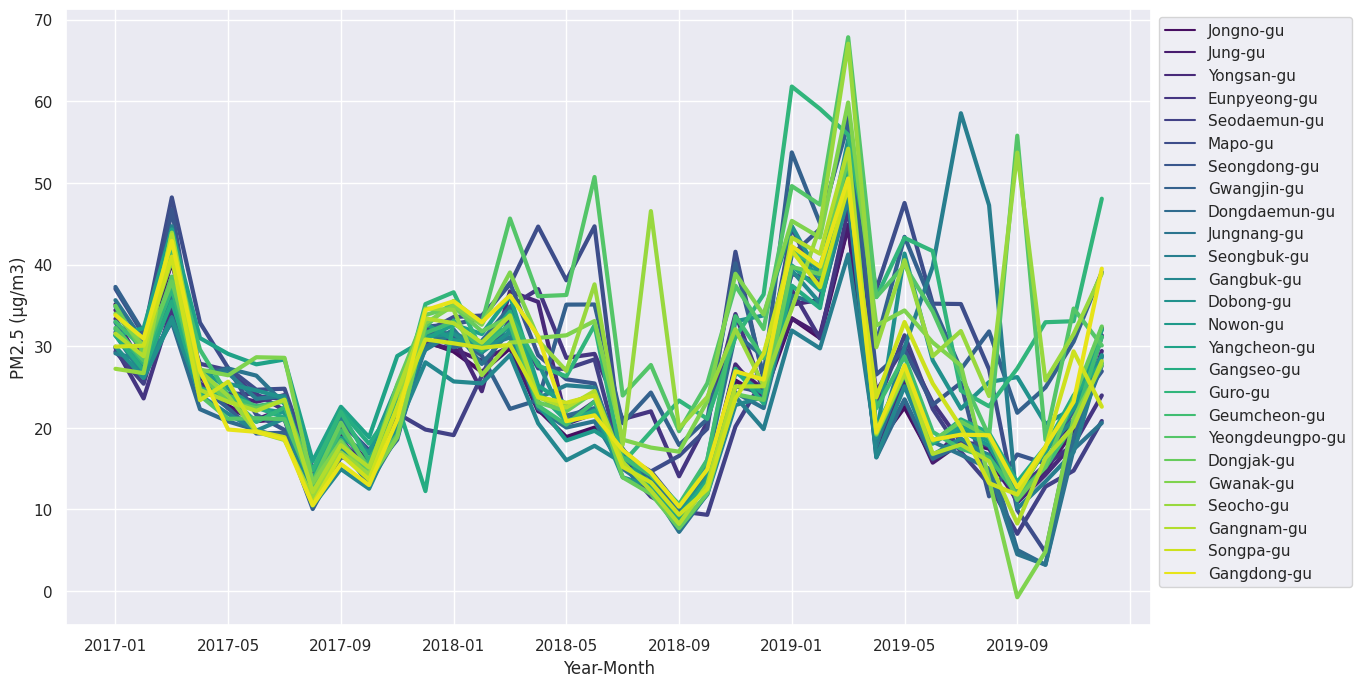

In [16]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=df_monthly, x ='YM', y = 'PM2.5',
                  hue='District', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('PM2.5 (µg/m3)')
plt.xlabel('Year-Month')
plt.show()

- 겹치는 Graph Line은 읽기 어렵습니다.
- 2017년에는 많은 관측소의 PM2.5 양이 같은 방향으로 갔음을 알 수 있습니다.
- 하지만 2018년과 2019년에는  Graph Line이 임의적으로 보이고 구분이 어렵습니다.

### 시각화 아이디어


#### 1. Interactive Chart
- Plotly는 Interactive Chart를 만들기 위한 그래프 라이브러리입니다.  
- Interactive Chart는 겹치는 선이 있는 영역을 확대하는 데 도움이 됩니다.

In [17]:
import plotly.graph_objects as go

#extract color palette, the palette can be changed
pal = list(sns.color_palette(palette='viridis', n_colors=len(list_scode)).as_hex())

fig = go.Figure()
for d,p in zip(list_district, pal):
    fig.add_trace(go.Scatter(x = df_monthly[df_monthly['District']==d]['YM'],
                             y = df_monthly[df_monthly['District']==d]['PM2.5'],
                             name = d,
                             line_color = p,
                             fill=None))   #tozeroy

fig.show()

 Interactive Area Chart

In [18]:
fig = go.Figure()
for d,p in zip(list_district, pal):
    fig.add_trace(go.Scatter(x = df_monthly[df_monthly['District']==d]['YM'],
                             y = df_monthly[df_monthly['District']==d]['PM2.5'],
                             name = d,
                             line_color = p,
                             fill='tozeroy'))   #tozeroy

fig.show()

#### 2. Small Multiple Time Series와 하나씩 비교.
- Seaborn 라이브러리를 사용하면 작은 다중 시계열을 수행할 수 있습니다.
- 이 플롯의 이면에 있는 아이디어는 각 라인을 다른 라인의 실루엣과 비교하면서 하나씩 플롯하는 것입니다.

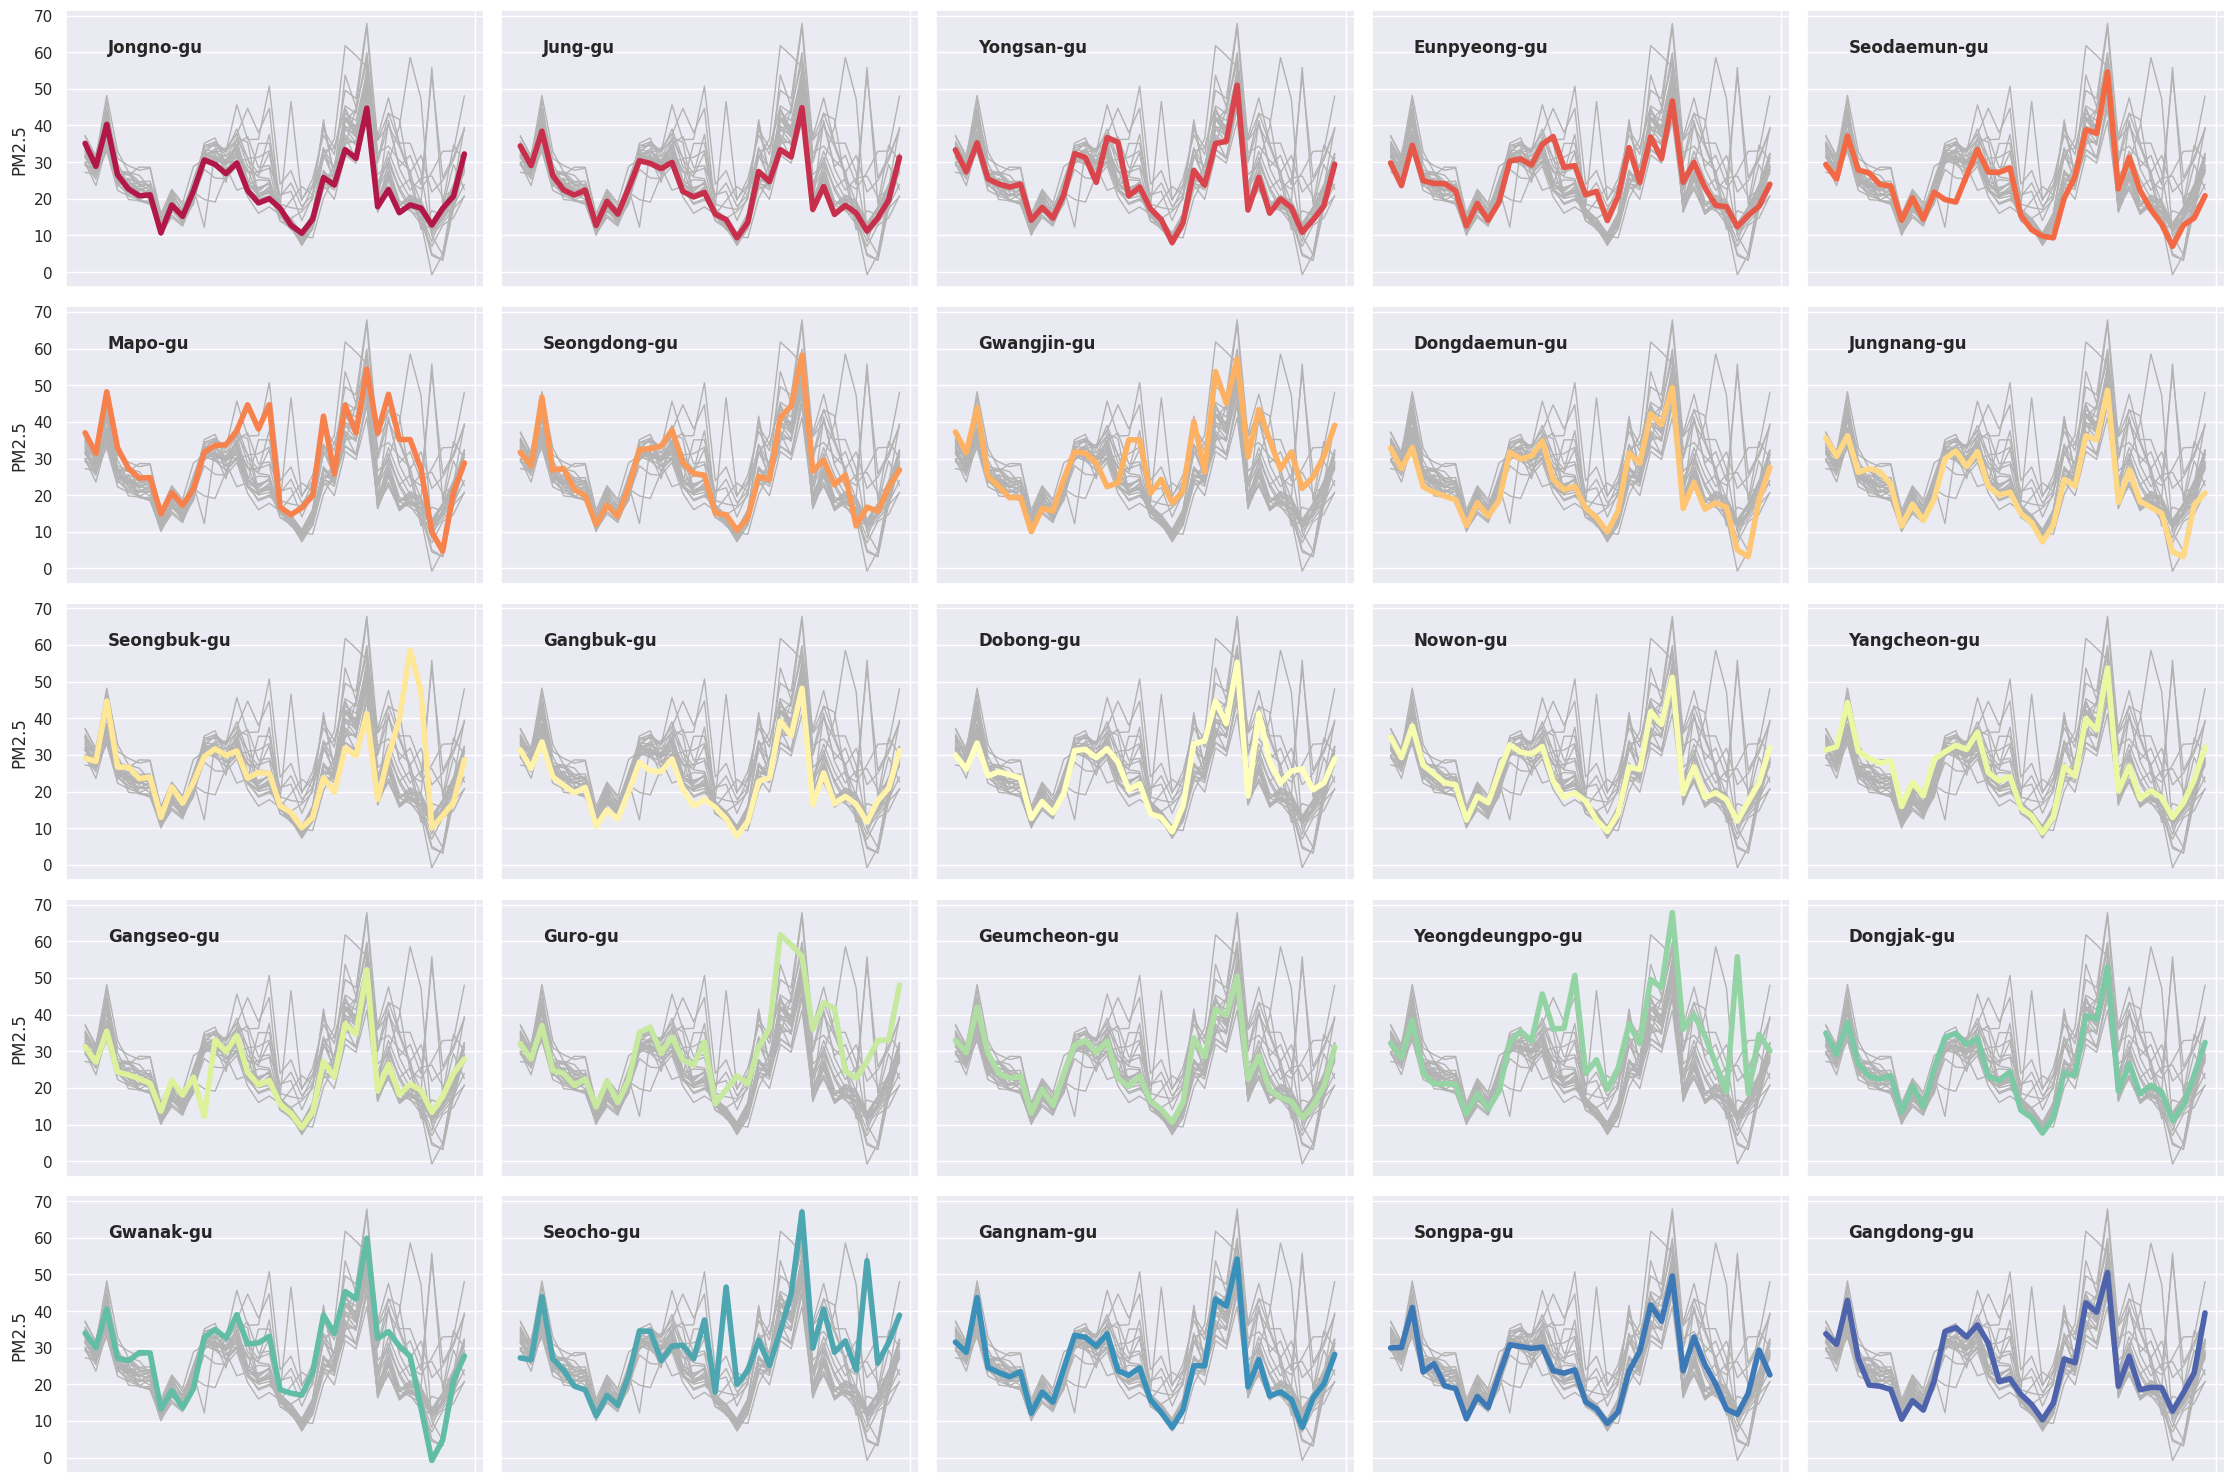

In [19]:
g = sns.relplot(data = df_monthly, x = "YM", y = "PM2.5",
                col = "District", hue = "District",
                kind = "line", palette = "Spectral",
                linewidth = 4, zorder = 5,
                col_wrap = 5, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = df_monthly, x = "YM", y = "PM2.5", units="District",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

ax.set_xticks('')
g.set_titles("")
g.set_axis_labels("", "PM2.5")
g.tight_layout()

#### 3. Facet Grid로 관점(point of view) 변경
- Seaborn의 FacetGrid를 사용하여 다중 플롯 그리드를 만들 수 있습니다.
- 이 경우 '월' 및 '연도' 속성은 각각 행과 열로 설정됩니다.
- 다른 관점에서 값은 수직으로 월간, 수평으로 연간 비교가 동시에 가능합니다.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/

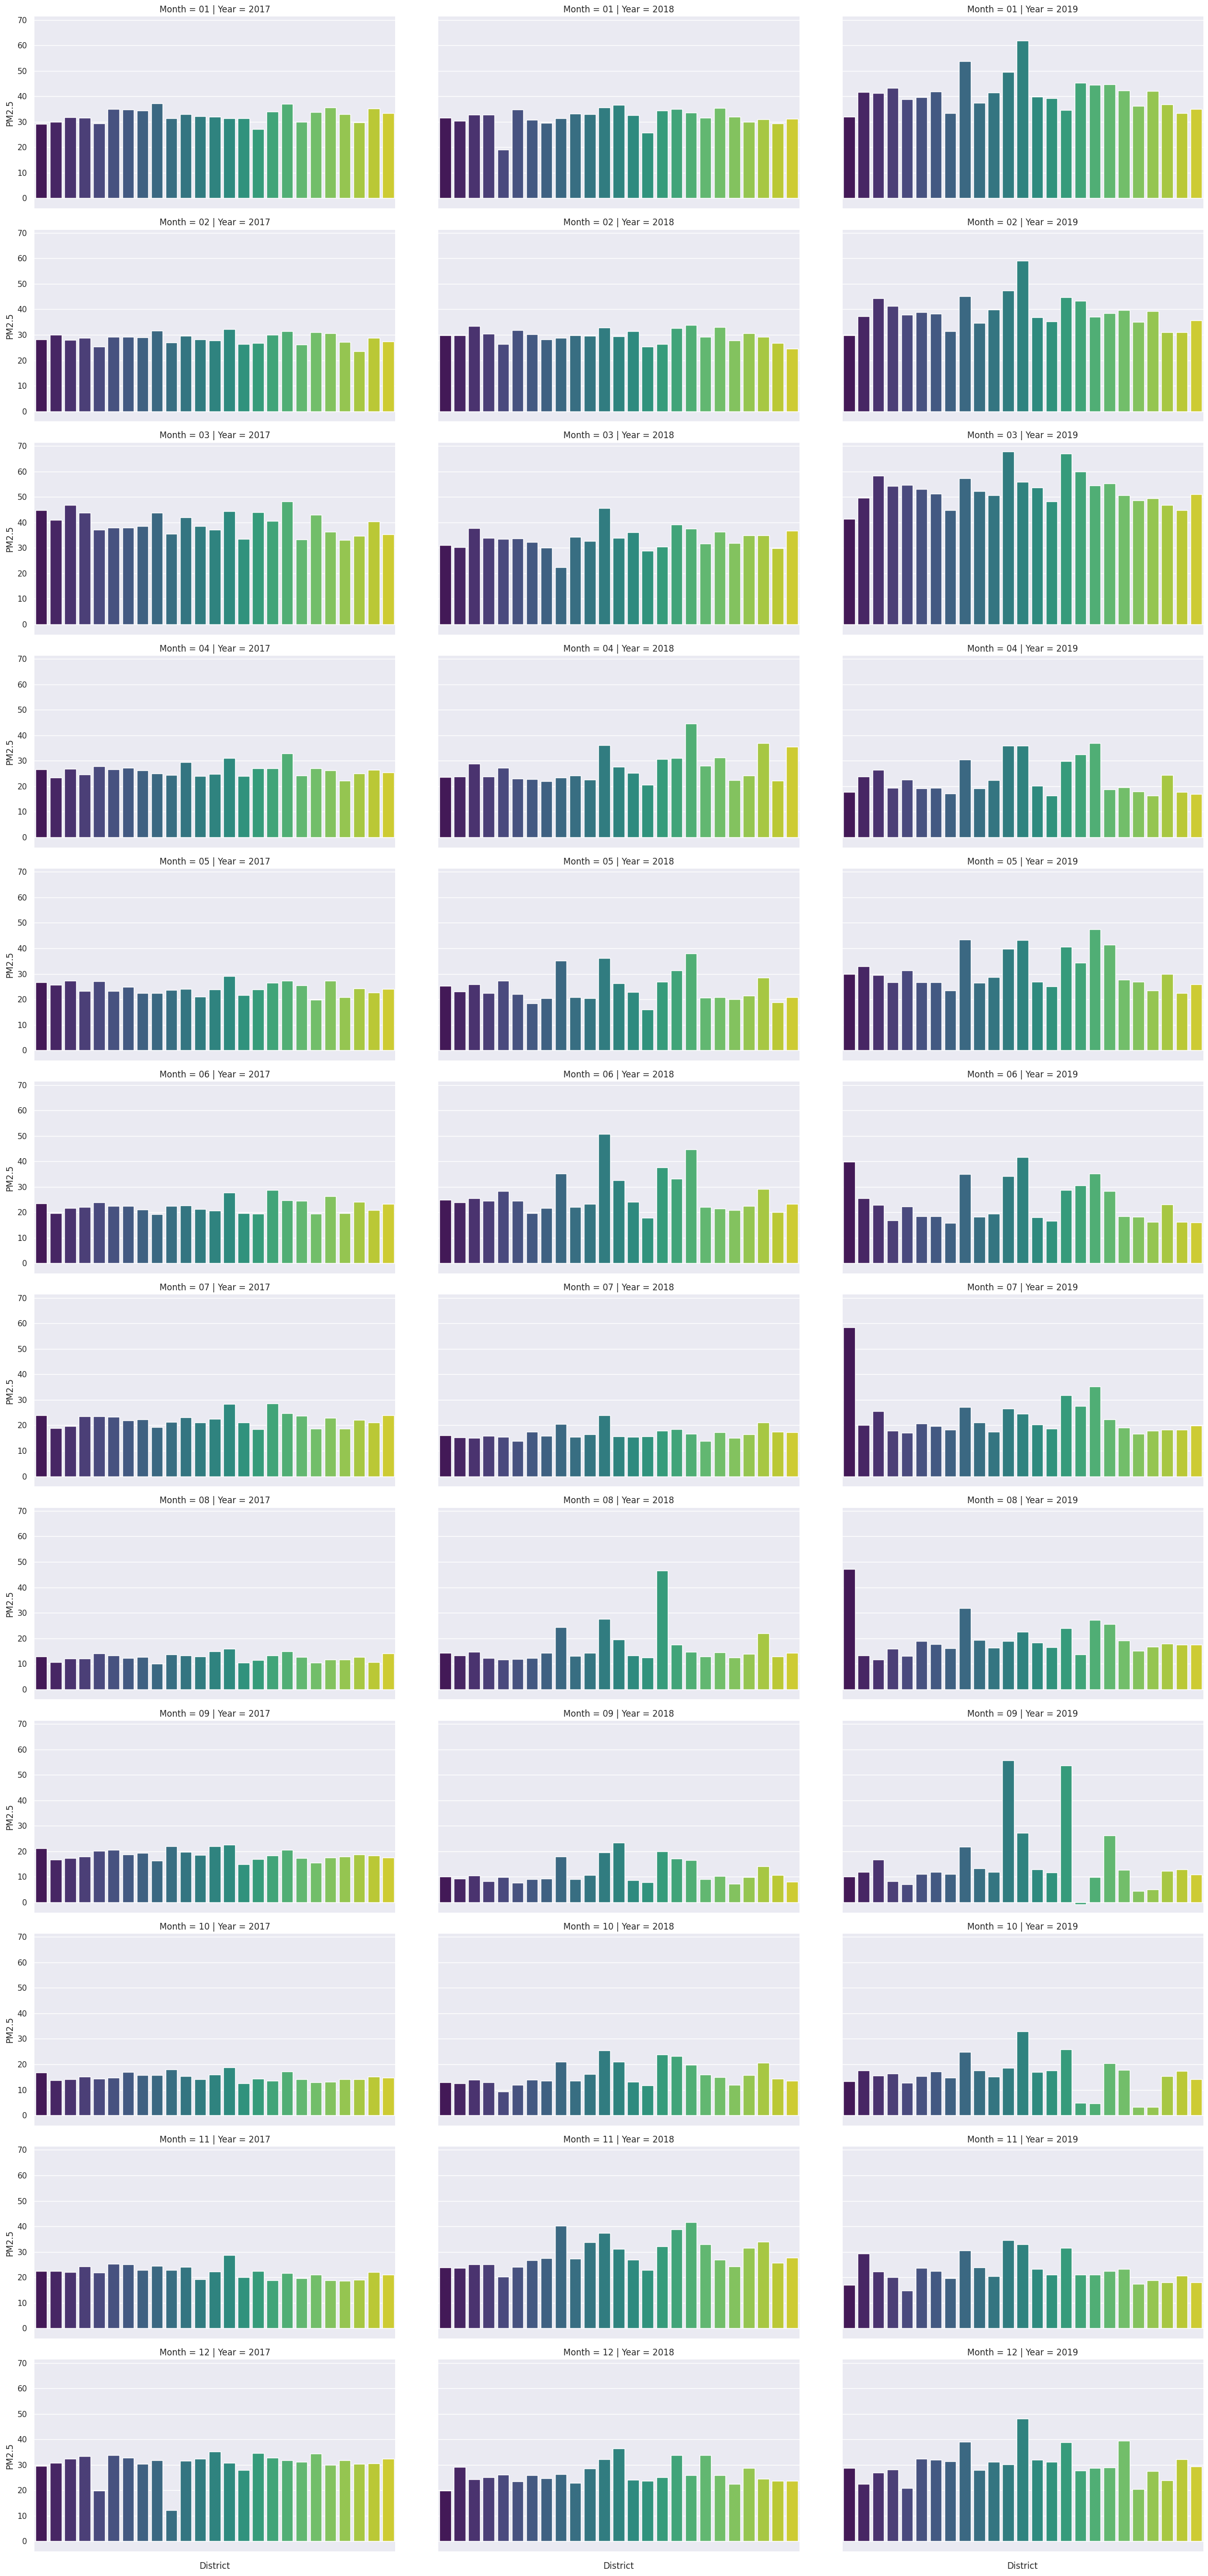

In [20]:
g = sns.FacetGrid(df_monthly, col="Year", row="Month", height=4.2, aspect=1.9)
g = g.map(sns.barplot, 'District', 'PM2.5', palette='viridis', ci=None, order = list_district)

g.set_xticklabels(rotation = 90)
plt.show()

#### 4. Heat Map 사용
- 히트맵은 데이터를 색상으로 값을 표시하는 2차원 차트로 나타냅니다.
- 시계열 데이터를 처리하기 위해 세로로 그룹을 설정하고 가로로 타임라인을 설정할 수 있습니다.
- 색상의 차이는 그룹을 구별하는 데 도움이 됩니다.

Pivot the DataFrame

In [21]:
df_pivot = pd.pivot_table(df_monthly,
                          values='PM2.5',
                          index='District',
                          columns='YM')
df_pivot

YM                 2017-01    2017-02    2017-03    2017-04    2017-05  \
District                                                                 
Dobong-gu        29.938172  26.101190  33.245968  24.245833  25.389785   
Dongdaemun-gu    32.892473  27.238095  32.967742  22.276389  20.774194   
Dongjak-gu       34.952957  29.187500  37.931452  26.590278  23.169355   
Eunpyeong-gu     29.771505  23.595238  34.607527  24.941667  24.189516   
Gangbuk-gu       31.387097  26.311012  33.530914  23.969444  21.713710   
Gangdong-gu      33.797043  30.922619  42.892473  27.000000  19.787634   
Gangnam-gu       31.529570  28.763393  43.662634  24.643056  23.193548   
Gangseo-gu       31.284946  27.037202  35.482527  24.338889  23.581989   
Geumcheon-gu     33.009409  29.656250  42.028226  29.568056  23.959677   
Guro-gu          32.073925  27.866071  37.030914  24.809722  23.934140   
Gwanak-gu        33.987903  30.019345  40.537634  27.131944  26.430108   
Gwangjin-gu      37.256720  31.625000  43.793011  25.106944  22.399194   
Jongno-gu        35.118280  28.857143  40.311828  26.536111  22.680108   
Jung-gu          34.412634  29.040179  38.438172  26.338889  22.388441   
Jungnang-gu      35.631720  30.569940  36.215054  26.213889  27.256720   
Mapo-gu          37.018817  31.367560  48.217742  32.873611  27.326613   
Nowon-gu         34.849462  29.255952  37.908602  27.211111  24.817204   
Seocho-gu        27.225806  26.691964  43.901882  26.954167  23.889785   
Seodaemun-gu     29.327957  25.398810  37.103495  27.843056  27.051075   
Seongbuk-gu      29.119624  28.212798  44.689516  26.654167  26.701613   
Seongdong-gu     31.702957  28.007440  46.716398  26.840278  27.298387   
Songpa-gu        29.946237  30.062500  40.967742  23.377778  25.647849   
Yangcheon-gu     31.306452  32.212798  44.301075  30.987500  29.048387   
Yeongdeungpo-gu  32.244624  28.255952  38.521505  23.958333  21.095430   
Yongsan-gu       33.338710  27.373512  35.255376  25.413889  24.024194   

YM                 2017-06    2017-07    2017-08    2017-09    2017-10  ...  \
District                                                                ...   
Dobong-gu        24.570833  23.674731  12.673387  17.268056  14.159946  ...   
Dongdaemun-gu    19.733333  18.737903  11.646505  17.954167  14.250000  ...   
Dongjak-gu       22.398611  23.310484  13.271505  20.622222  14.750000  ...   
Eunpyeong-gu     24.125000  22.129032  12.572581  18.712500  14.106183  ...   
Gangbuk-gu       19.647222  21.142473  10.440860  14.944444  12.534946  ...   
Gangdong-gu      19.504167  18.595430  10.498656  15.556944  12.981183  ...   
Gangnam-gu       22.076389  23.450269  12.126344  17.863889  15.145161  ...   
Gangseo-gu       22.508333  21.232527  13.684140  22.069444  18.051075  ...   
Geumcheon-gu     22.655556  23.217742  13.178763  19.681944  15.272849  ...   
Guro-gu          20.711111  22.491935  14.822581  21.916667  16.013441  ...   
Gwanak-gu        28.643056  28.569892  13.268817  18.269444  13.620968  ...   
Gwangjin-gu      19.297222  19.384409  10.048387  16.383333  15.676075  ...   
Jongno-gu        20.816667  21.071237  10.704301  18.275000  15.213710  ...   
Jung-gu          21.002778  22.373656  12.717742  19.286111  15.797043  ...   
Jungnang-gu      26.390278  22.908602  11.575269  17.533333  13.108871  ...   
Mapo-gu          24.658333  24.786290  14.928763  20.665278  17.256720  ...   
Nowon-gu         22.395833  21.856183  12.235215  18.780556  16.955645  ...   
Seocho-gu        19.502778  18.497312  11.432796  16.975000  14.286290  ...   
Seodaemun-gu     23.875000  23.504032  14.131720  20.243056  14.430108  ...   
Seongbuk-gu      23.544444  23.923387  12.962366  21.236111  16.818548  ...   
Seongdong-gu     21.600000  19.731183  11.971774  17.331944  14.202957  ...   
Songpa-gu        19.581944  18.838710  10.614247  16.698611  13.657258  ...   
Yangcheon-gu     27.773611  28.364247  15.911290  22.575000  18.842742  ...   
Yeongdeungpo-gu  21.173611

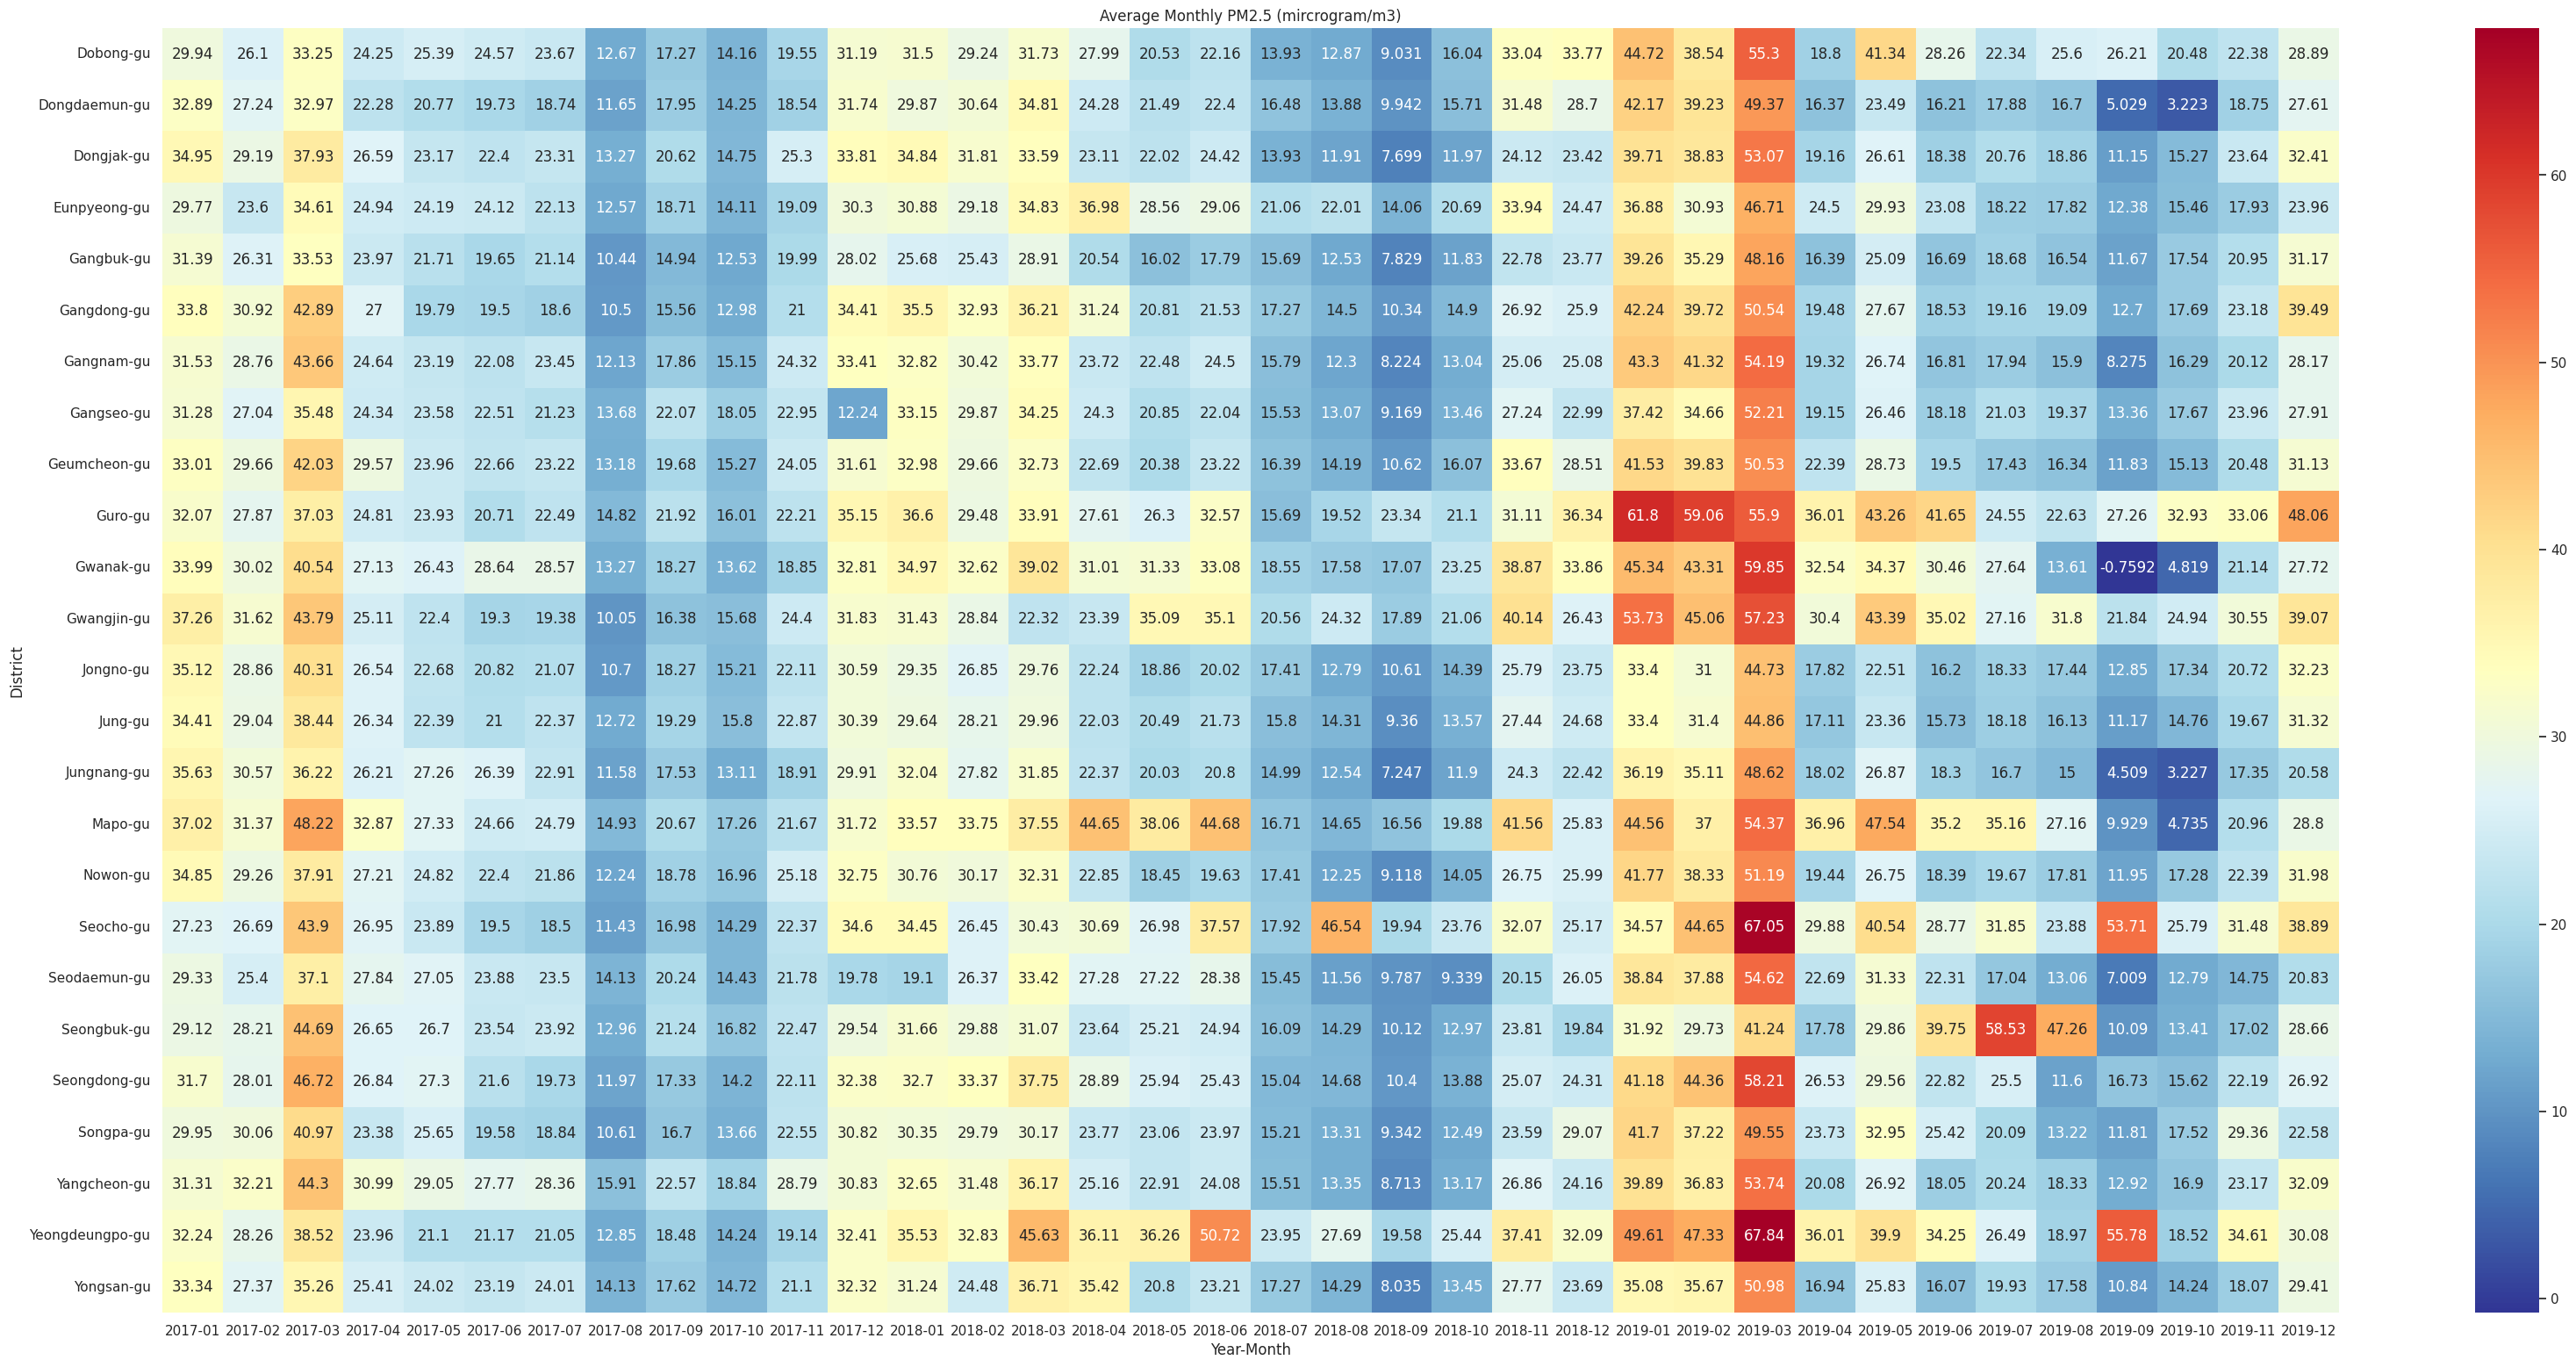

In [22]:
plt.figure(figsize = (40,19))
plt.title('Average Monthly PM2.5 (mircrogram/m3)')

sns.heatmap(df_pivot, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.xlabel('Year-Month')
plt.ylabel('District')
plt.show()

#### 5. Radar chart 각도 사용하기
- 인터랙티브 Radar Chart를 생성하기 위해 Plotly의 산점도에 각도 축을 설정할 수 있습니다.
- 매월은 원의 변수로 선택됩니다. 예로 2019년 25개 지역의 평균 월간 PM2.5를 비교하는 레이더 차트를 생성합니다.

In [23]:
df_19 = df_monthly[df_monthly['Year']=='2019']

In [24]:
import plotly.graph_objects as go

#extract color palette, the palette name can be changed
pal = list(sns.color_palette(palette='viridis', n_colors=len(list_scode)).as_hex())

months = list(reversed([str(i) for i in list(range(1,13))])) + ['12']
list_PM = [[list(df_19[df_19['District']==i]['PM2.5'])[int(n)-1] for n in months] for i in list_district]

fig = go.Figure()
for pm,d,c in zip(list_PM, list_district, pal):
    fig.add_trace(go.Scatterpolar(r = pm, theta=months, fill= None,
                                  name=str(d), marker = dict(color = c)))

fig.update_layout(polar = dict(radialaxis = dict(visible = True, range=[0, 70]),
                               angularaxis = dict(rotation=90)),
                  showlegend=True, width=720, height=720,
                  font = dict(size=14))

fig.show()

#### 6. Radial Plot
- Radial Plot은 직교 좌표 대신 극좌표를 사용하는 막대 차트를 기반으로 합니다. - 이 차트 유형은 서로 멀리 떨어져 있는 범주를 비교할 때 불편하지만 주의를 끌기에 탁월한 선택입니다. 인포그래픽에서 사용할 수 있습니다.
- 아래 예는 2019년 1월 25개 지역의 평균 PM2.5를 보여주는 방사형 플롯의 예를 보여줍니다.

In [25]:
list_month19 = list(set(df_19['Month']))
list_YM19 = list(set(df_19['YM']))
list_YM19.sort()
listdf_monthly19 = [df_19[df_19['Month']==str(i)] for i in list_month19]

In [26]:
#set color palette, lower and max values
pal = list(sns.color_palette(palette='CMRmap_r', n_colors=len(list_district)).as_hex())
lowerLimit = 0
max_v = df_19['PM2.5'].max()

def radial_plot(input_df, column_name, title):
    input_df.reset_index(inplace=True, drop=True)
    plt.figure(figsize=(12,12))
    ax = plt.subplot(111, polar=True)
    plt.axis()

    heights = input_df[column_name]
    width = 2*np.pi / len(input_df.index)

    indexes = list(range(1, len(input_df.index)+1))
    angles = [element * width for element in indexes]

    bars = ax.bar(x=angles, height=heights, width=width, bottom=lowerLimit,
                  linewidth=1, edgecolor="white", color=pal)

    labelPadding = 2

    for bar, angle, height, label in zip(bars, angles, heights, list_district):
        rotation = np.rad2deg(angle)
        alignment = ""

        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else:
            alignment = "left"

        ax.text(x=angle, y=lowerLimit + bar.get_height() + labelPadding,
                s=label, ha=alignment, va='center', rotation=rotation,
                rotation_mode="anchor")

        ax.set_thetagrids([], labels=[])
        plt.title("Average PM2.5 // " + title)
    return ax

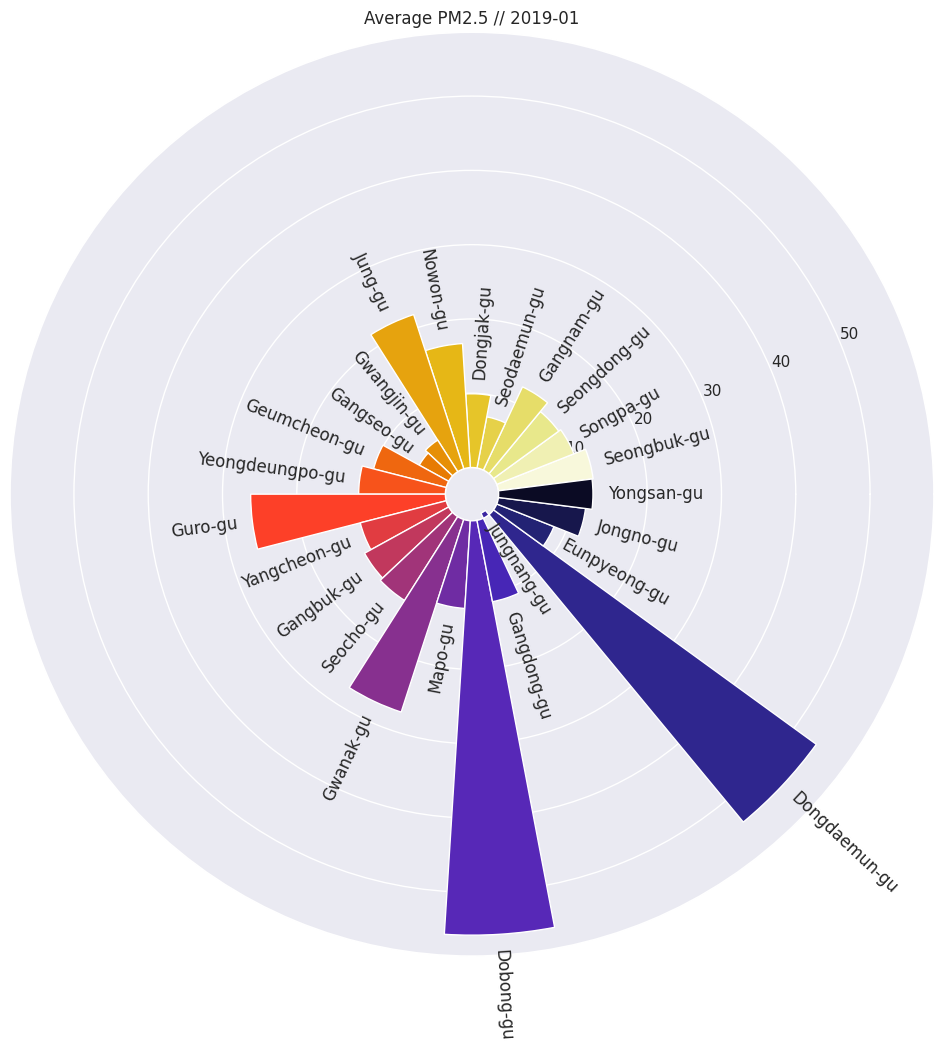

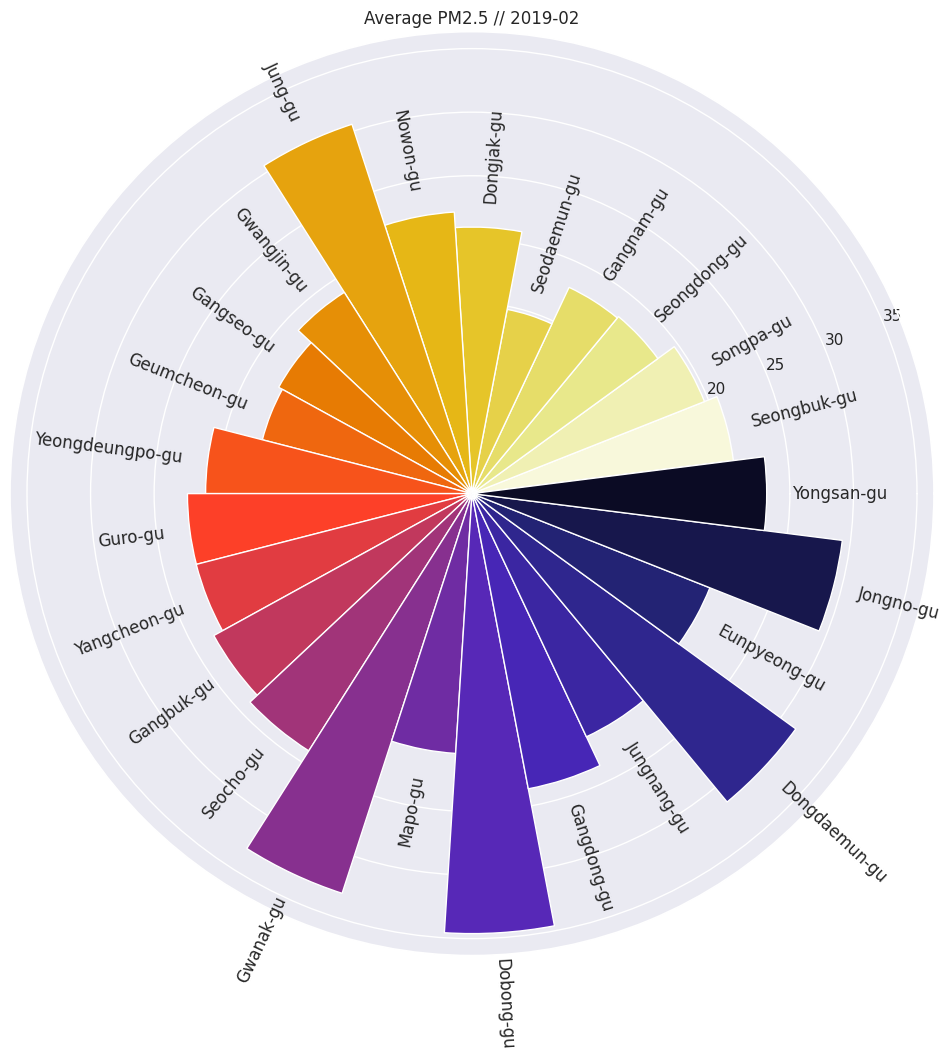

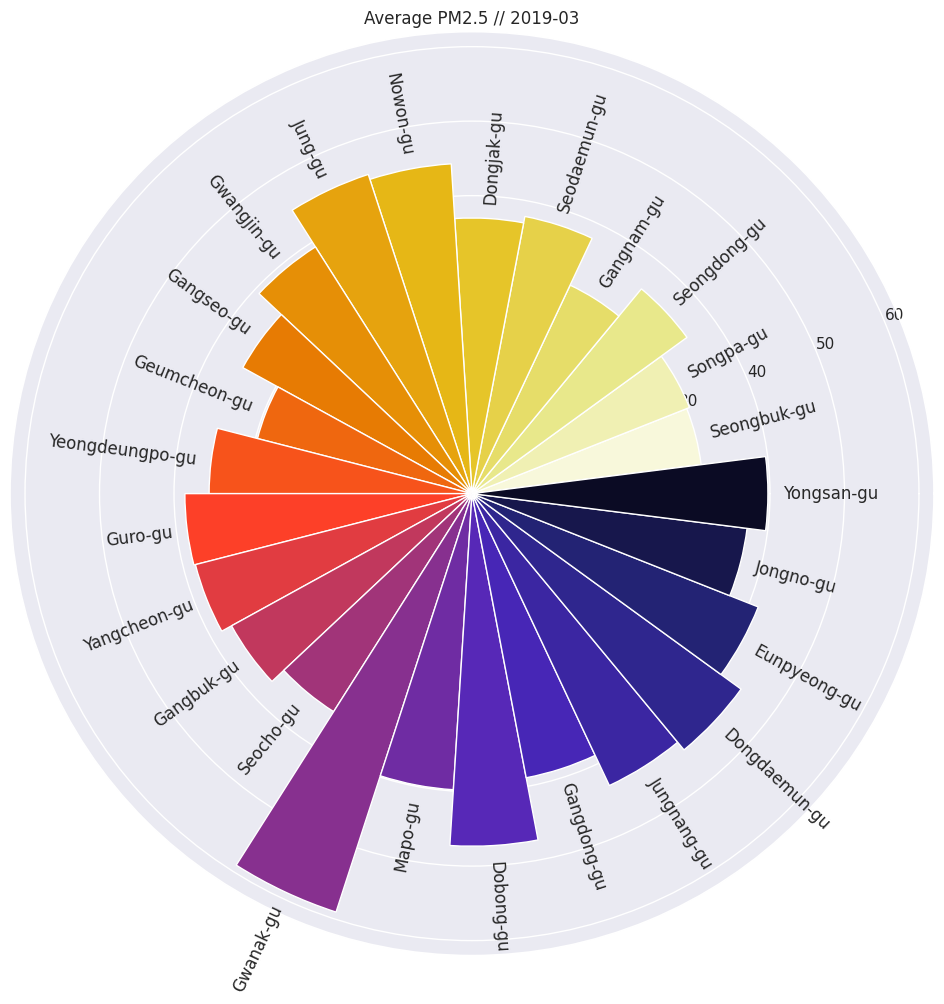

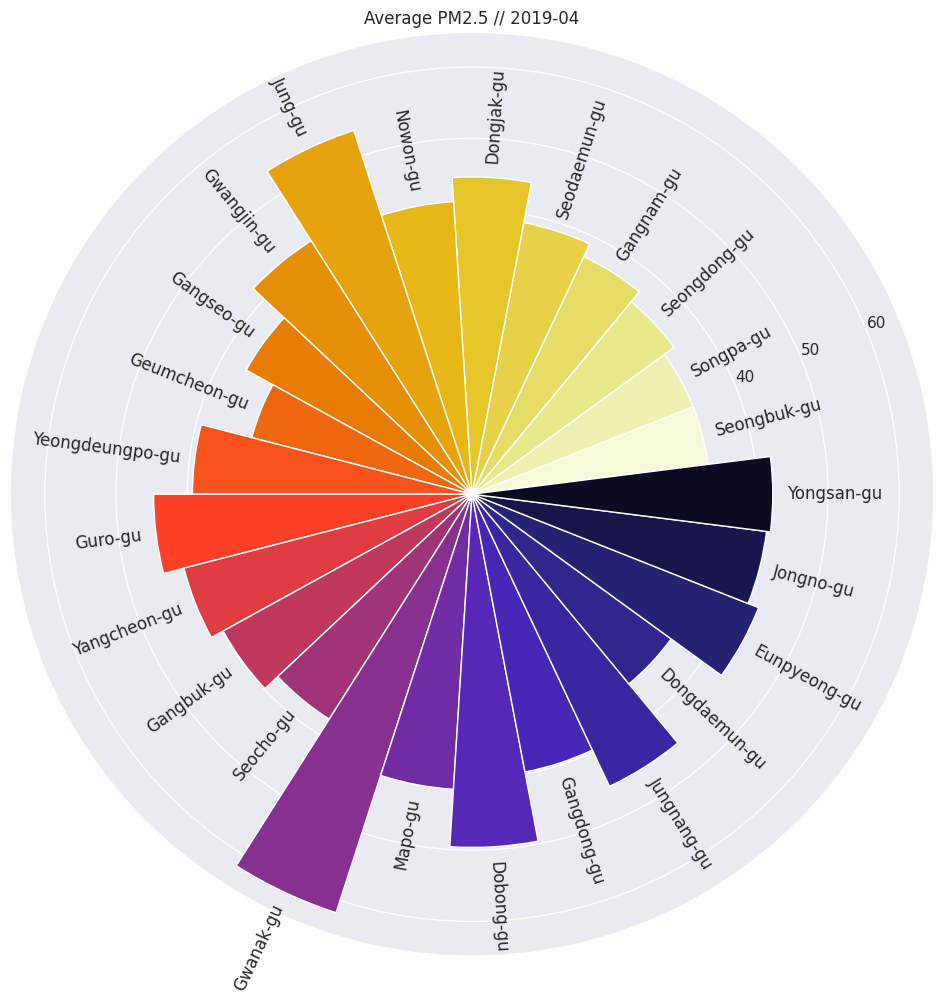

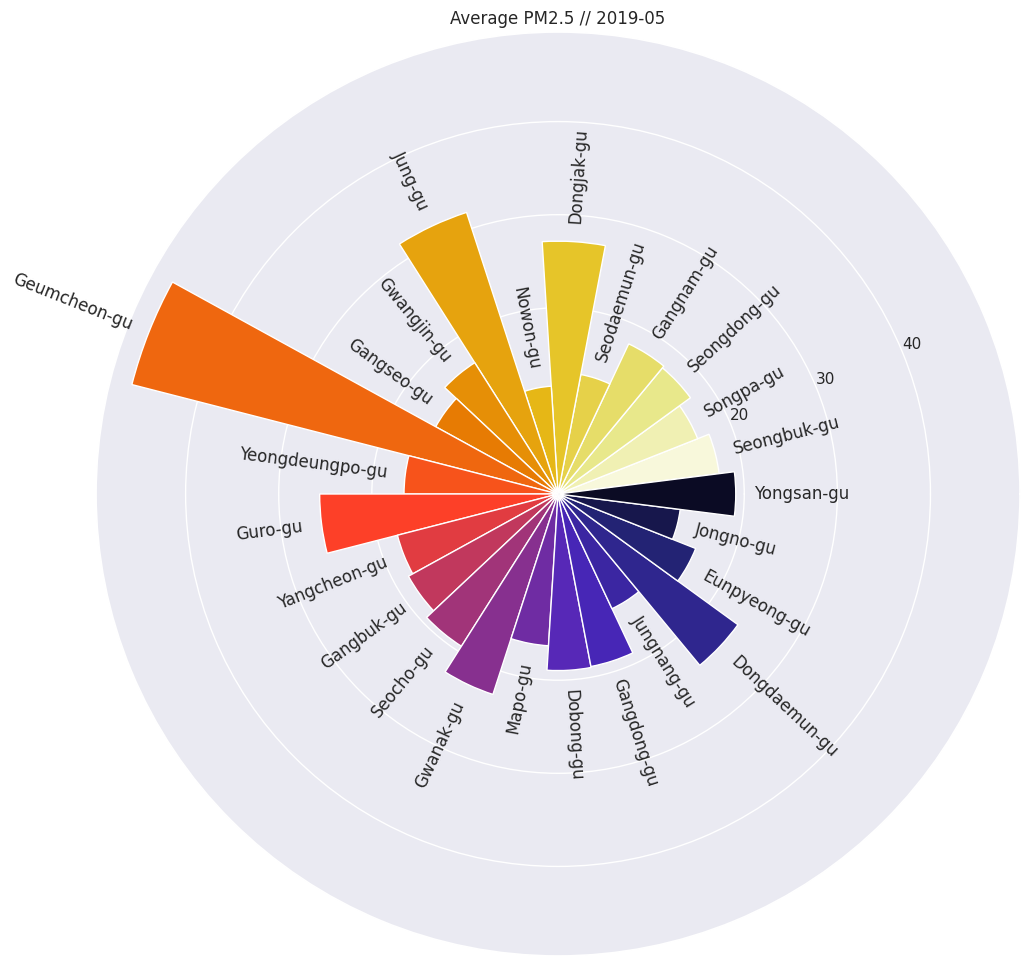

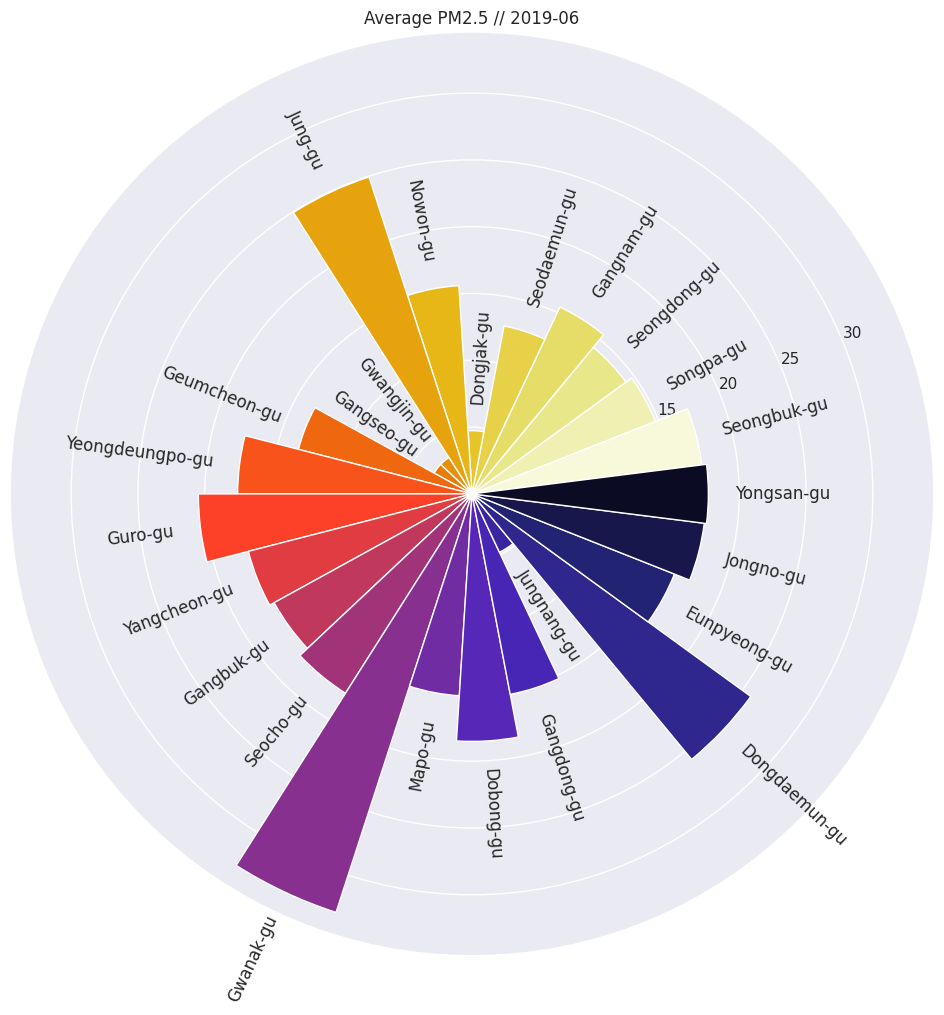

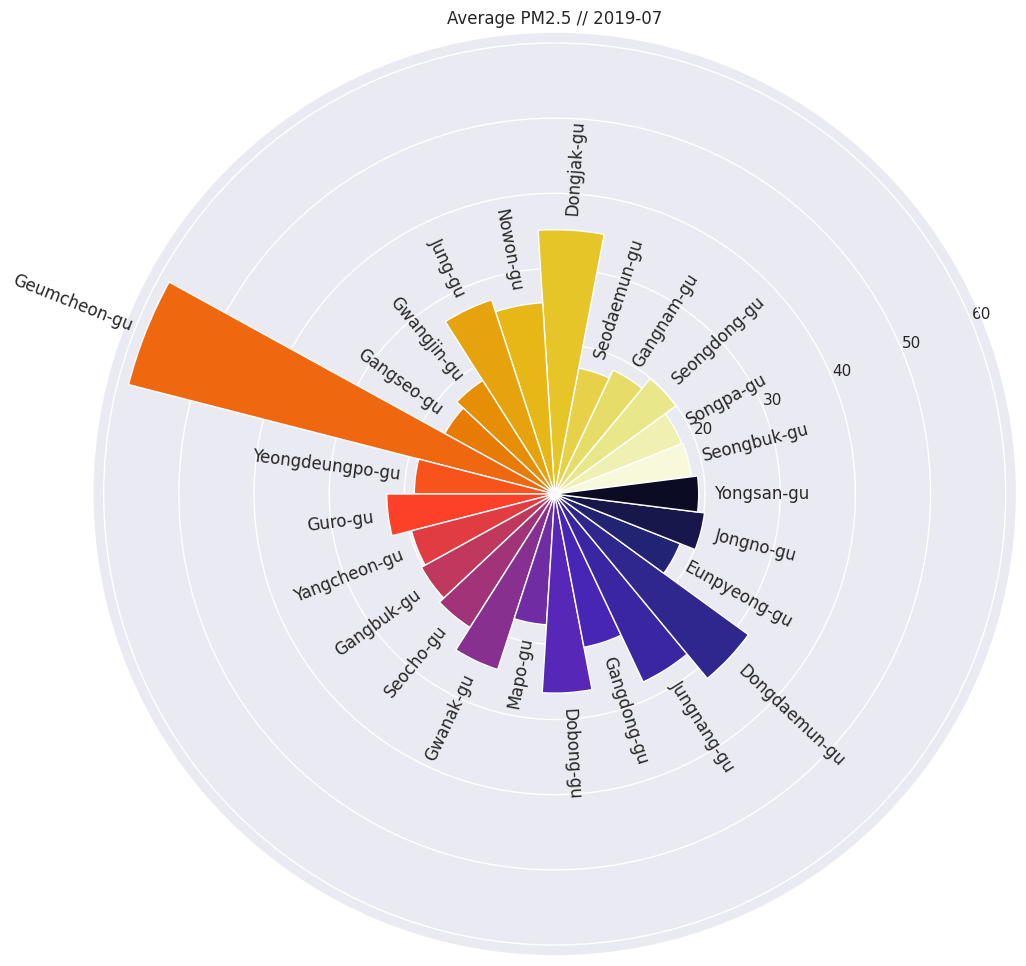

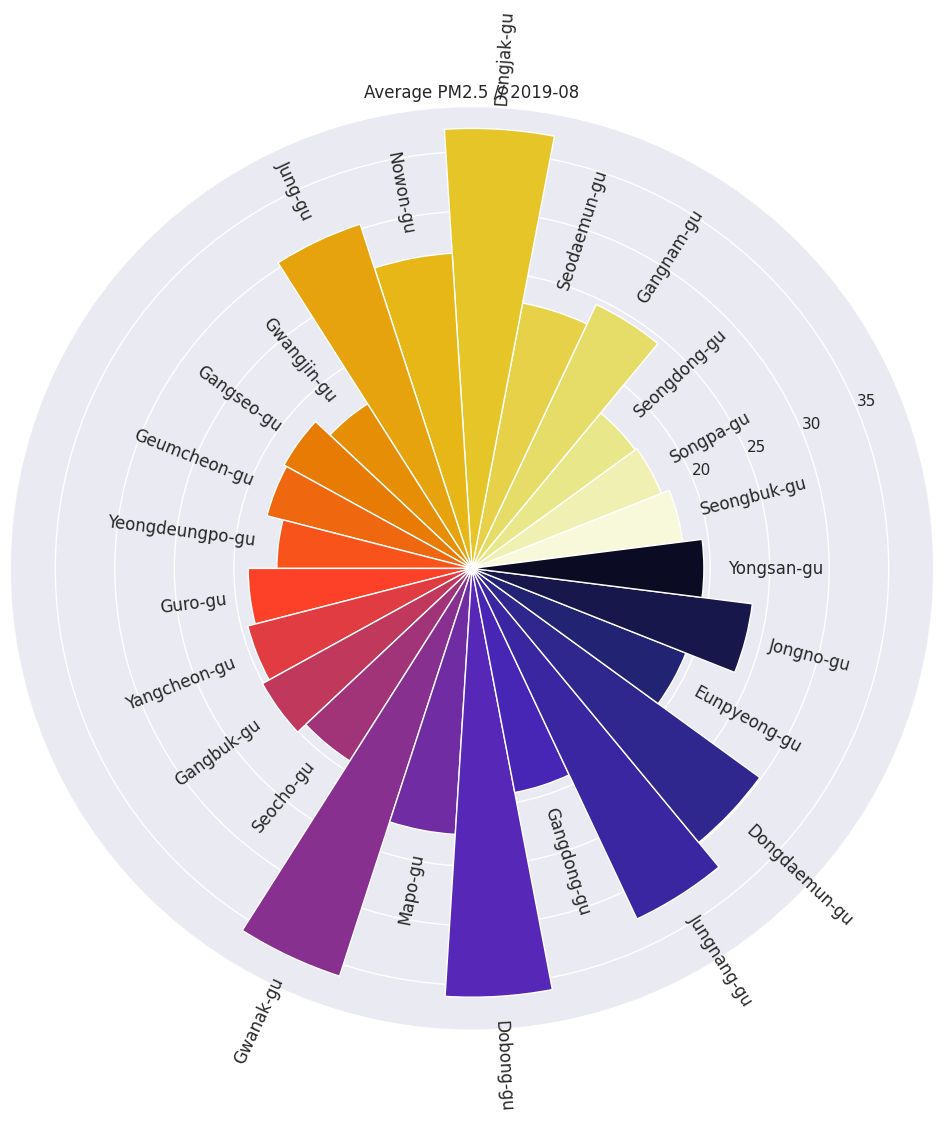

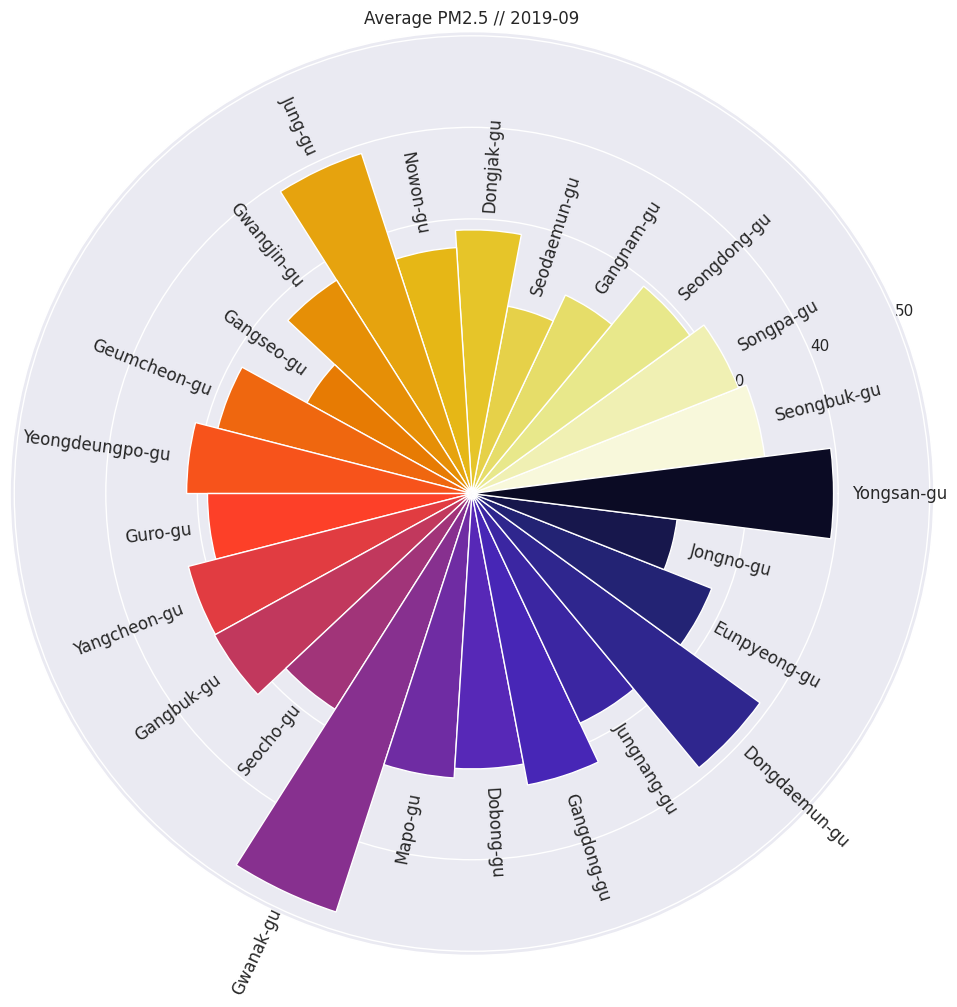

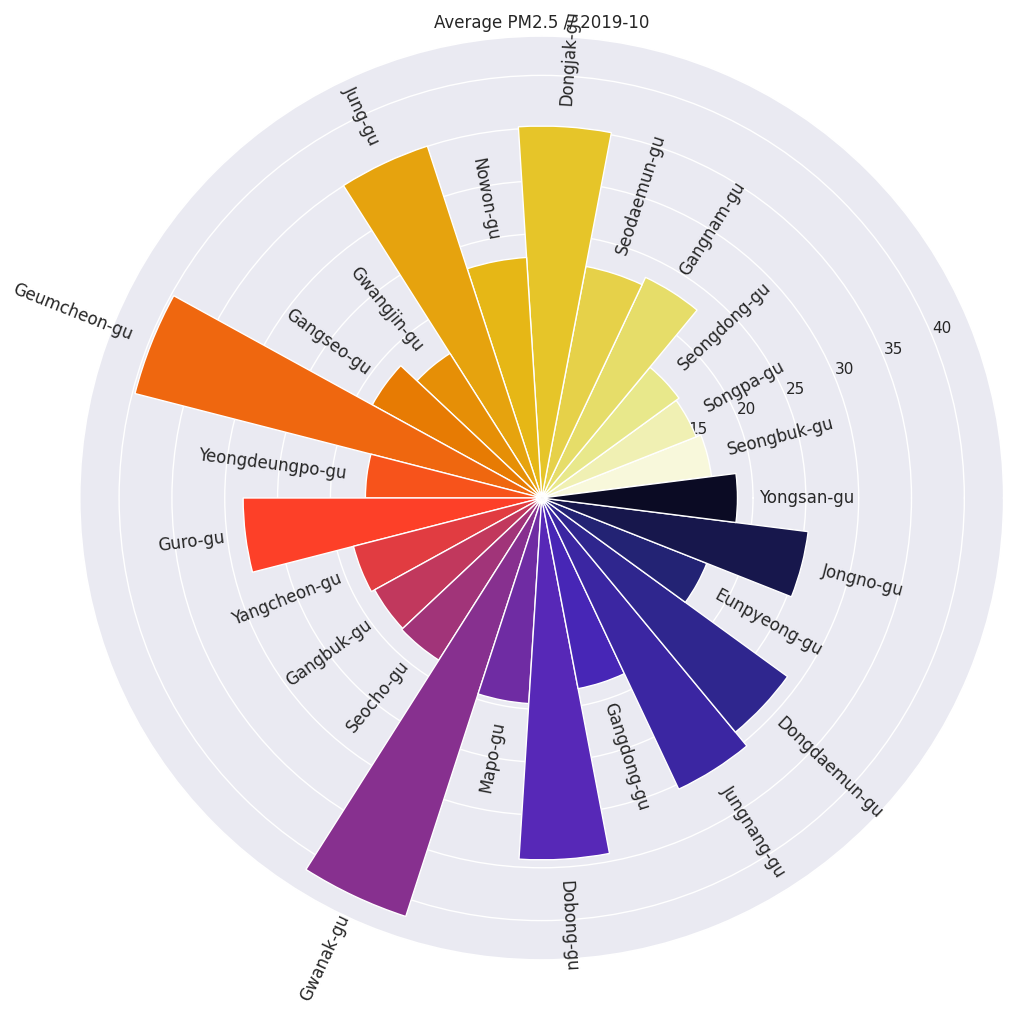

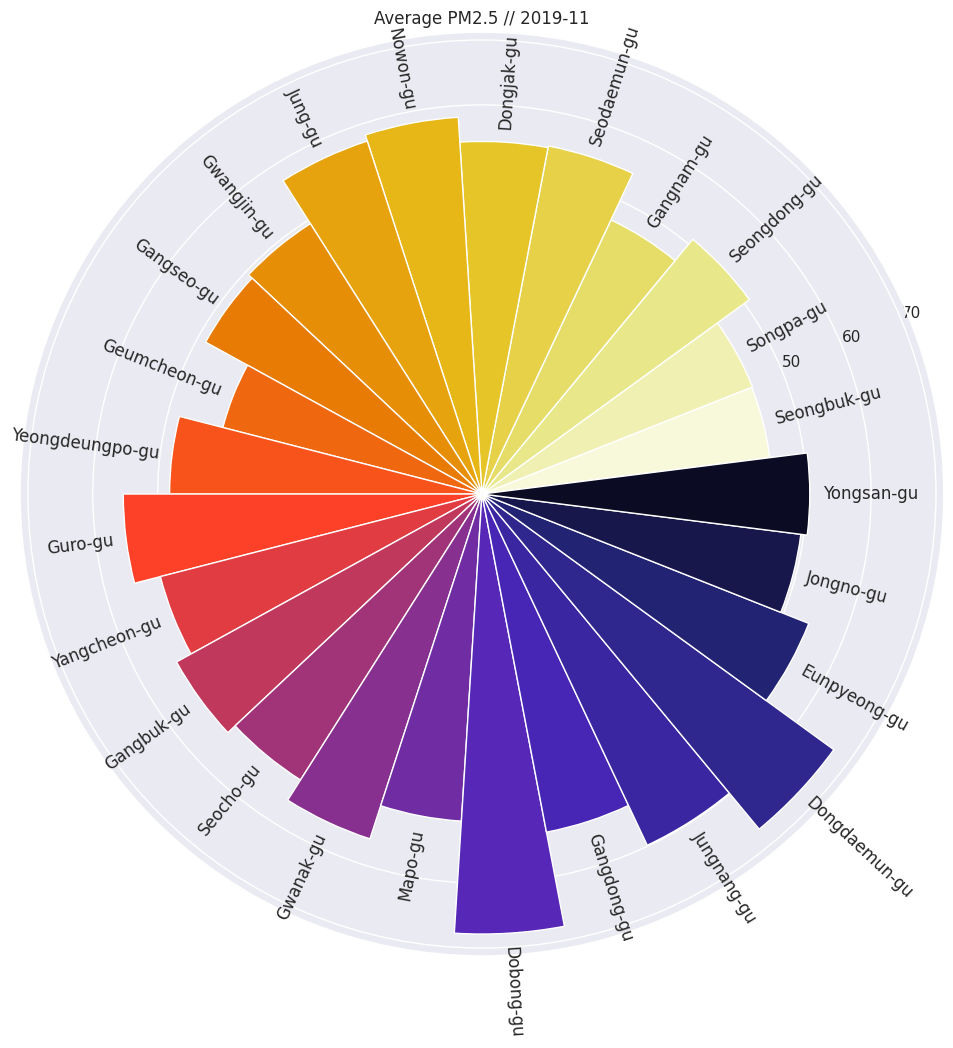

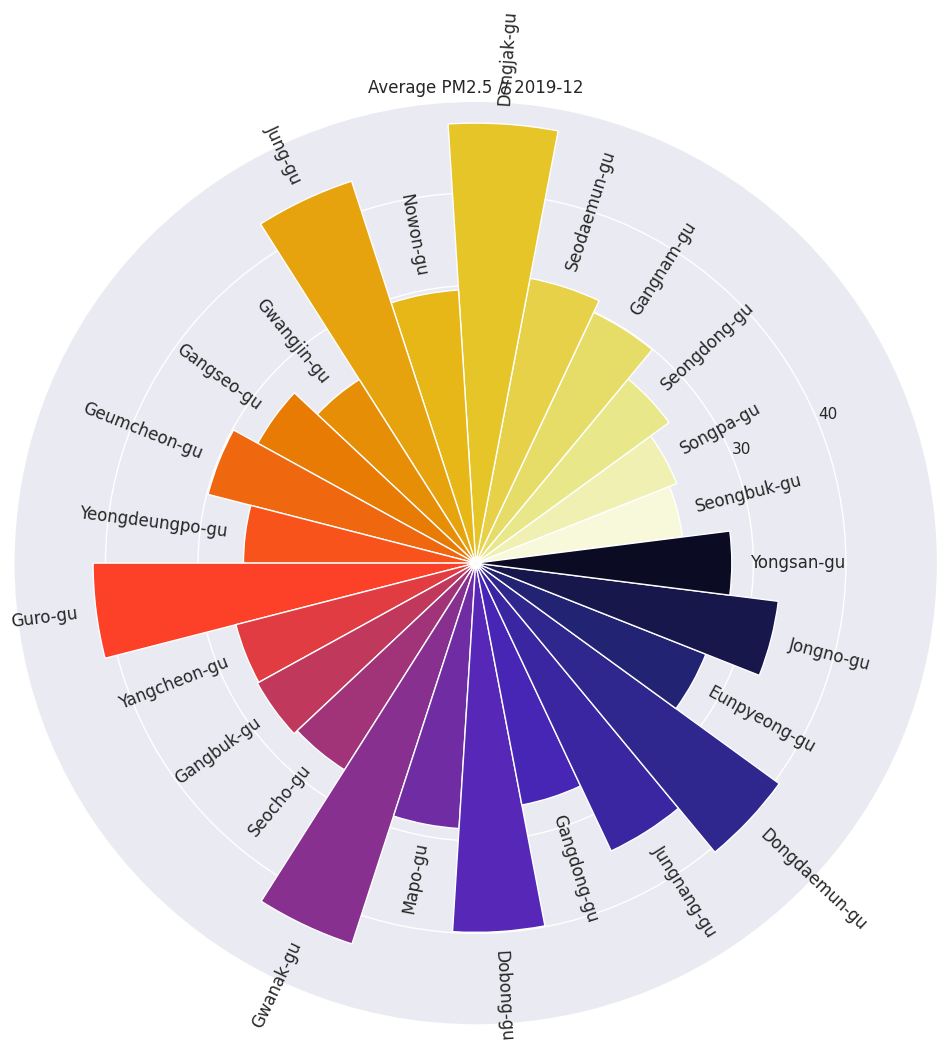

In [27]:
keep_sname = []
order = range(len(listdf_monthly19))

for i in order:
    radial_plot(listdf_monthly19[i], 'PM2.5', list_YM19[i])
    keep_sname.append('rad_bar_' + str(i) + '.png')
    plt.savefig('rad_bar_' + str(i) + '.png')
    plt.show()

#### 8. Ridge plot : 중첩 밀도 표시
- 릿지 플롯은 축을 타임라인으로 설정하여 여러 시계열 데이터와 함께 사용할 수 있습니다.
- 다음 예는 2019년 한 지역의 PM2.5 밀도가 있는 Ridge 플롯의 예를 보여줍니다.

In [28]:
#change color scale for 12 months
pal = list(sns.color_palette(palette='viridis', n_colors=len(list_month19)).as_hex())

def kde_ridge(df_input, col_name, time, title):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Initialize the FacetGrid object
    g = sns.FacetGrid(df_input, row= time, hue=time, aspect=15, height=0.65, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, col_name,
          bw_adjust=.5, clip_on=False,fill=True, alpha=1, linewidth=1.5)

    g.map(sns.kdeplot, col_name, clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,ha="left", va="center", transform=ax.transAxes)

    g.map(label, time)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="", xlabel= title + ' PM2.5')
    g.despine(bottom=True, left=True)

    return g

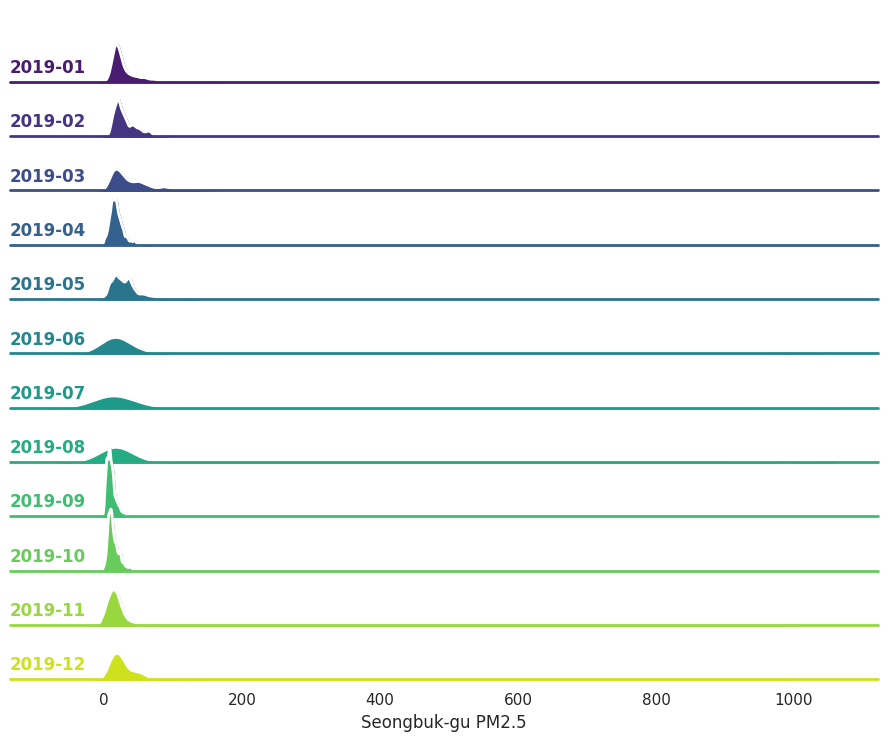

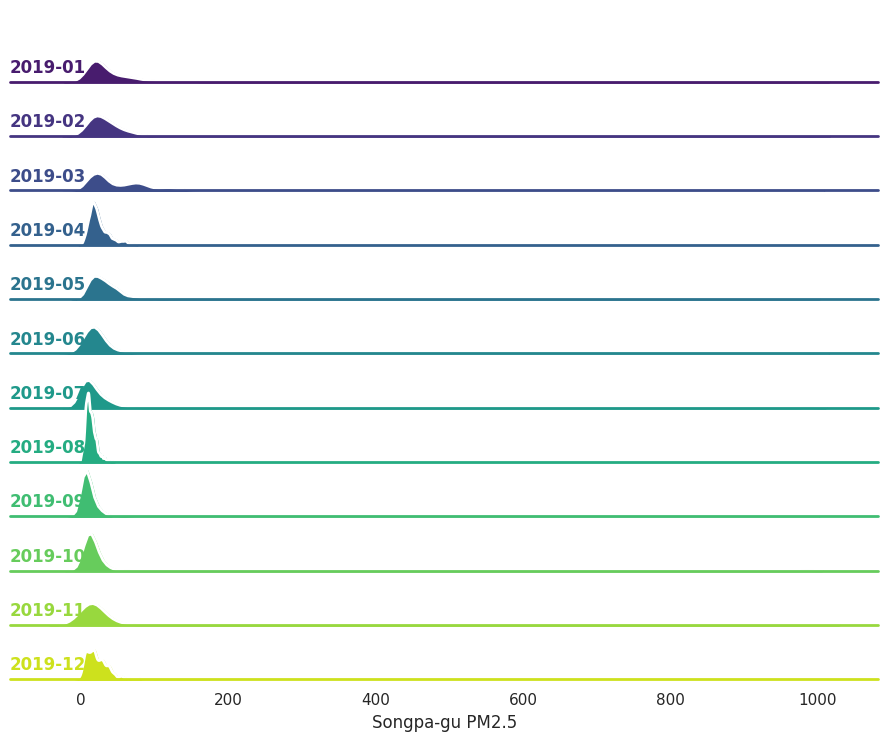

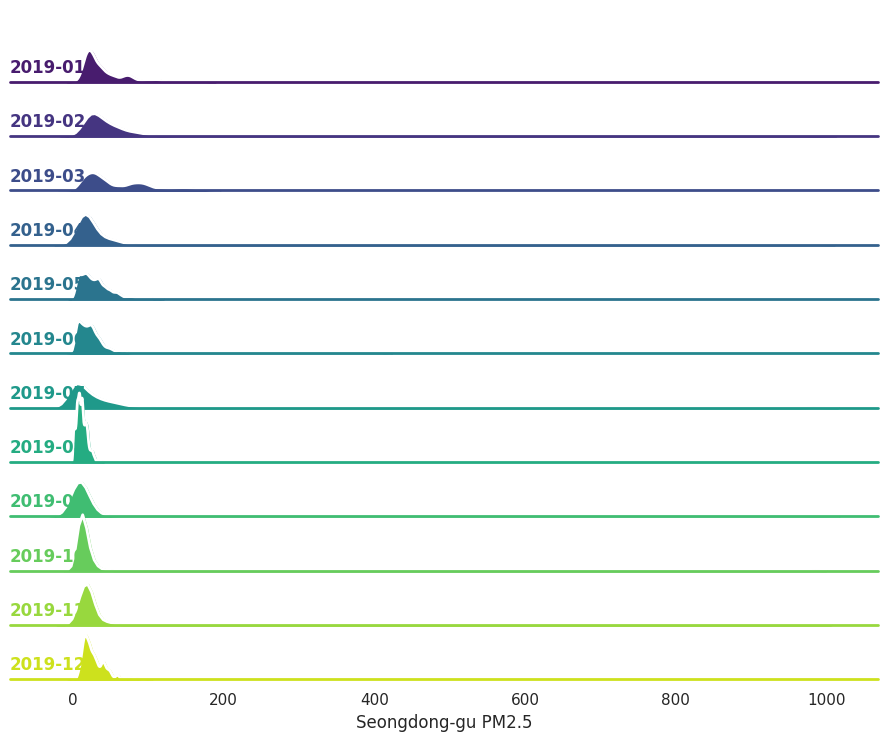

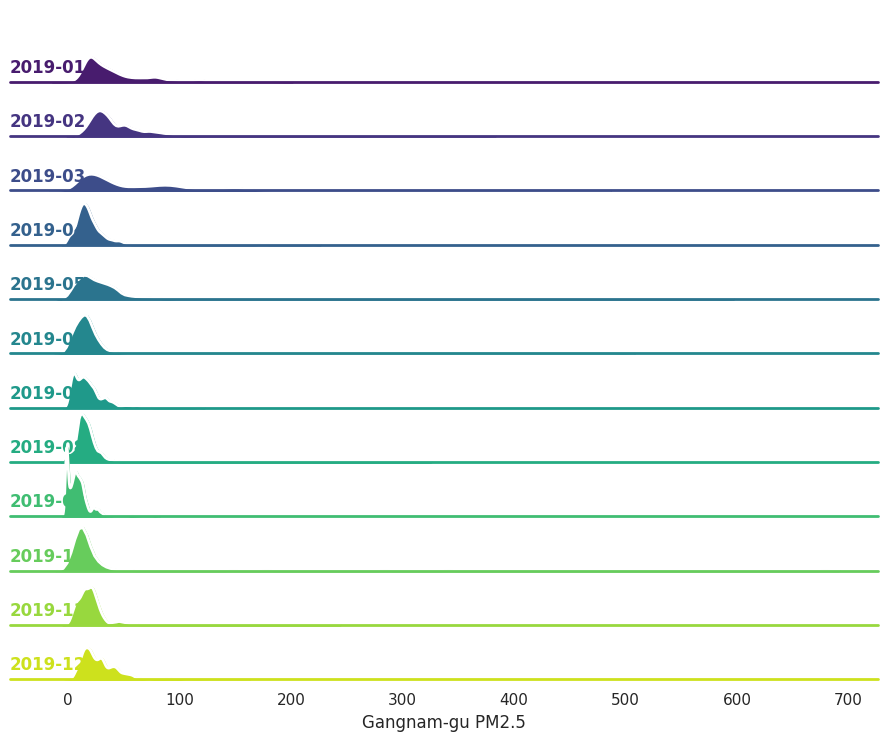

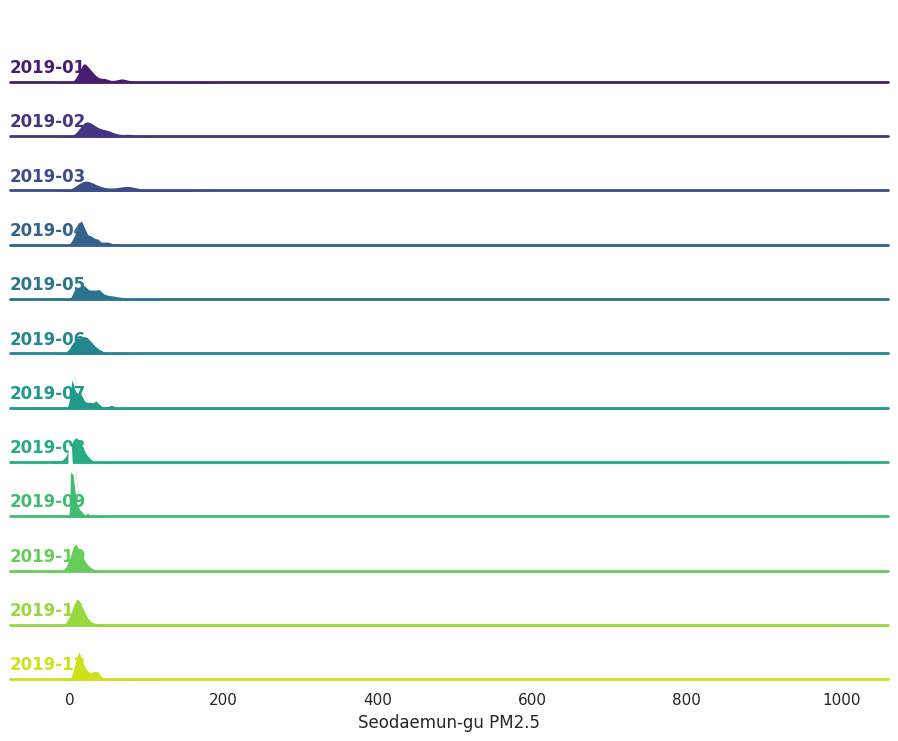

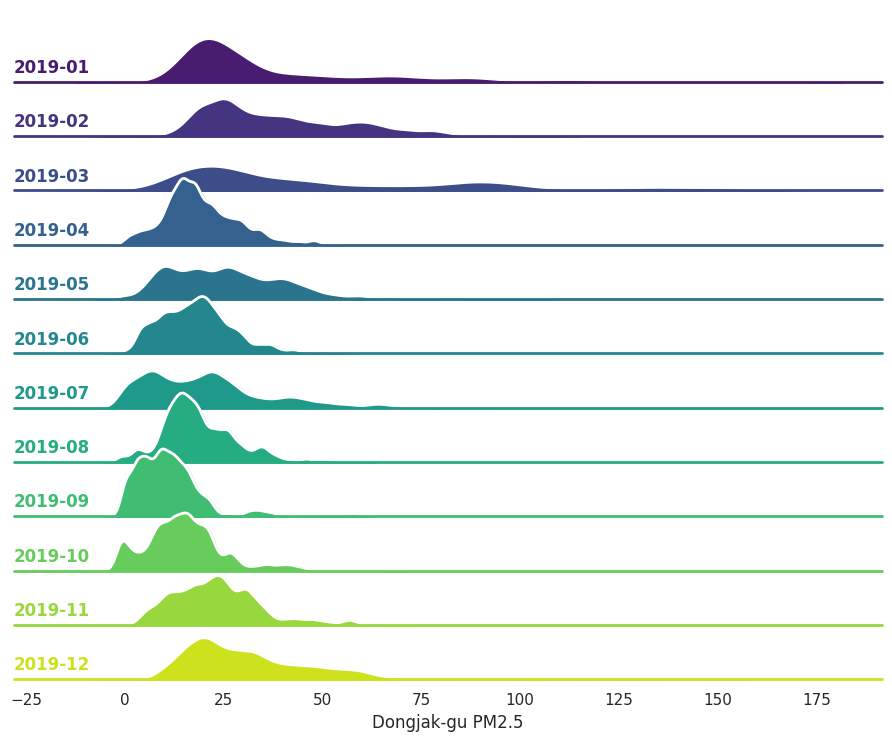

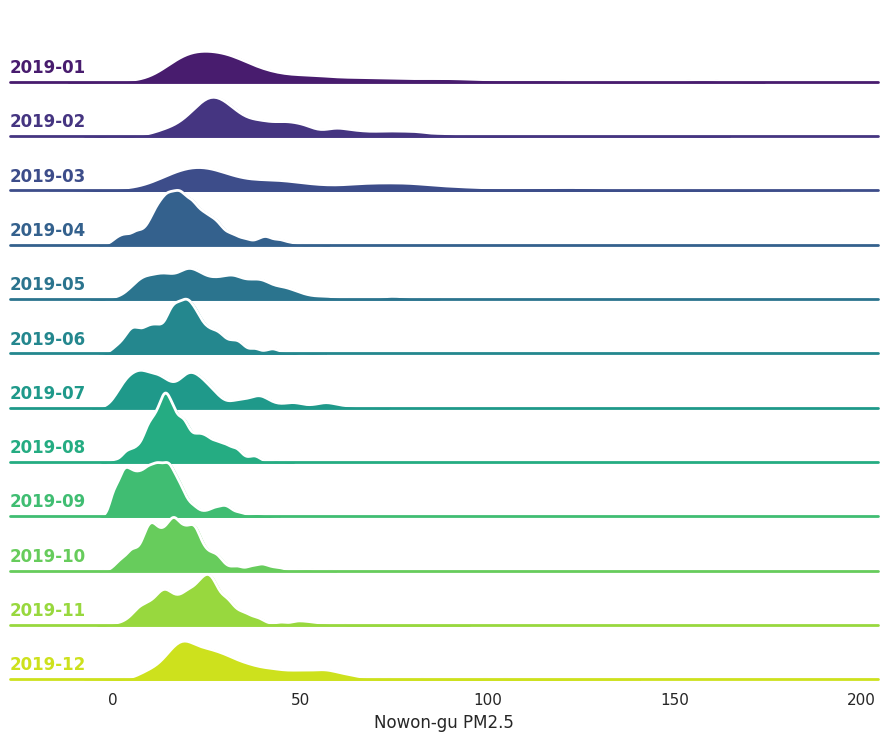

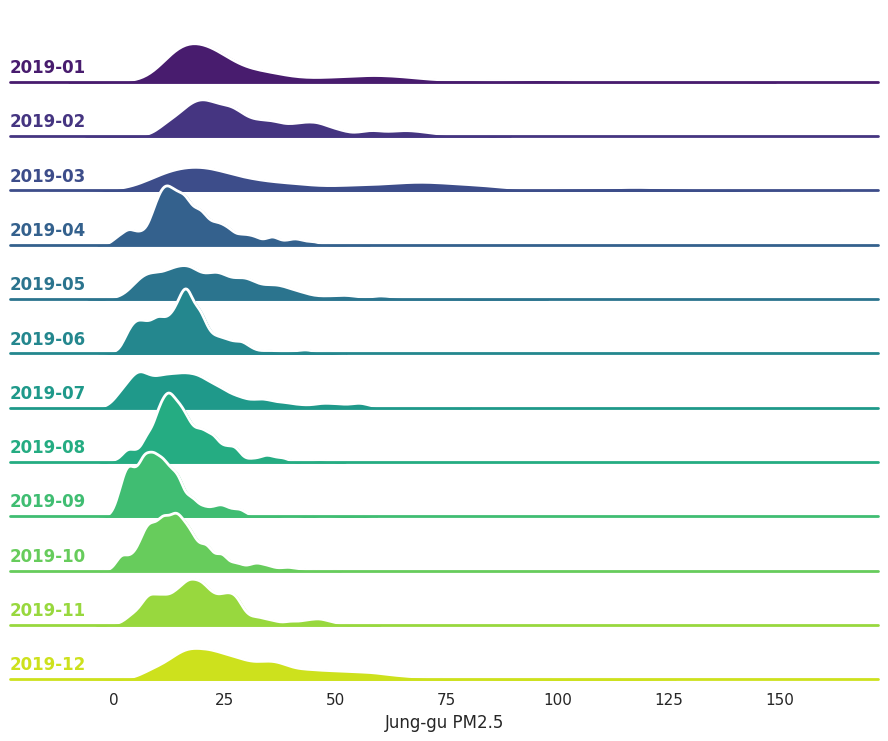

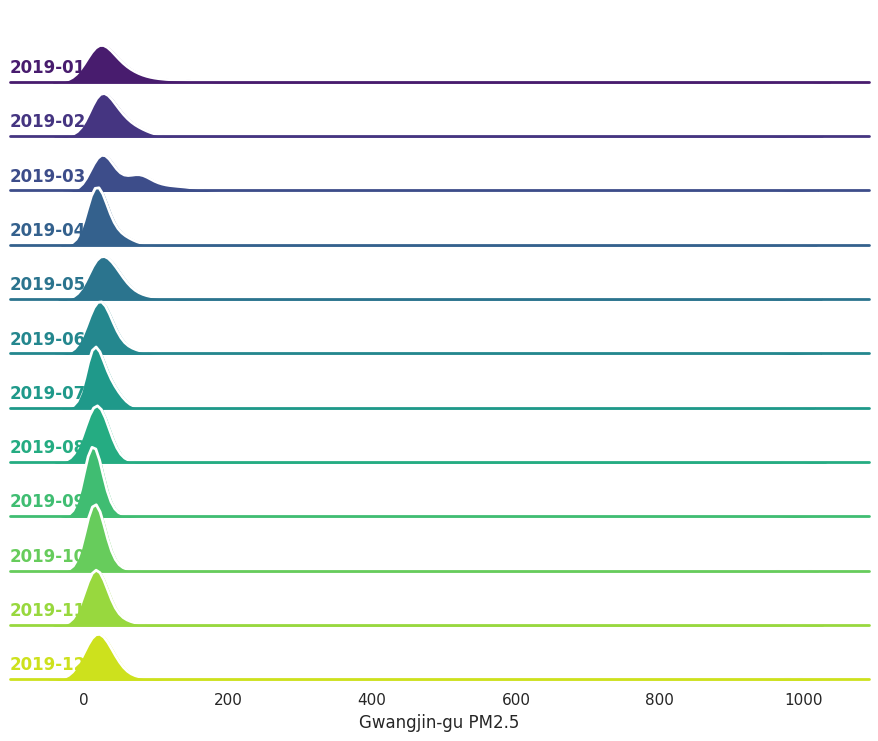

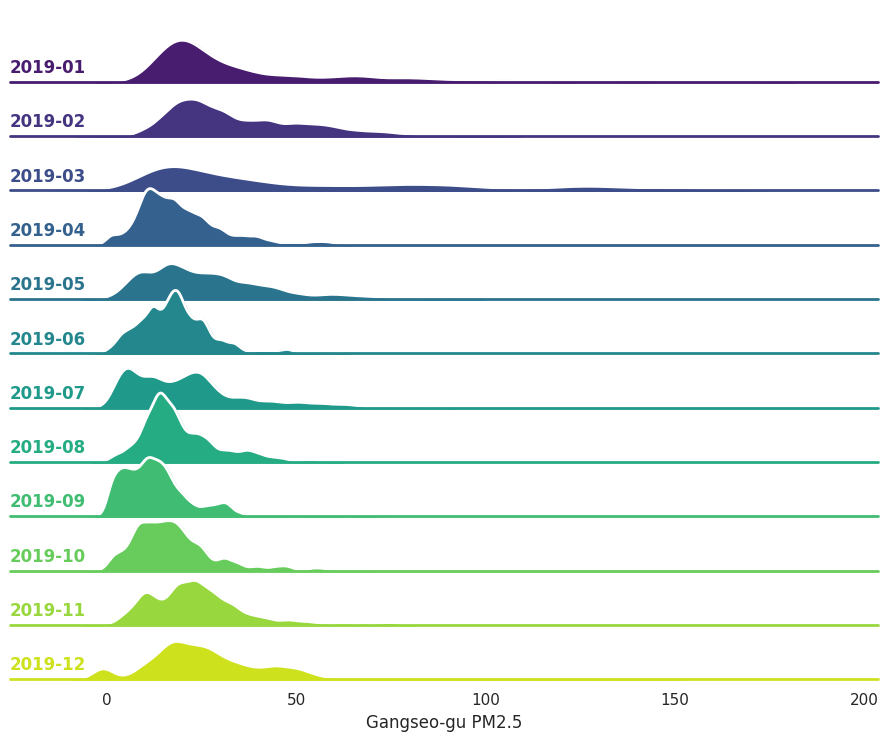

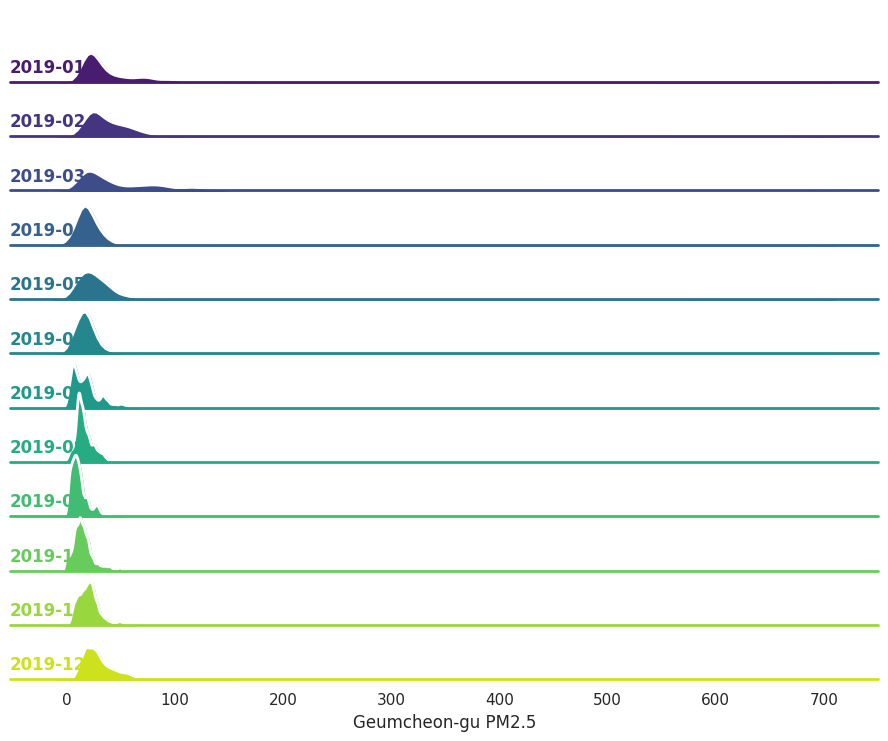

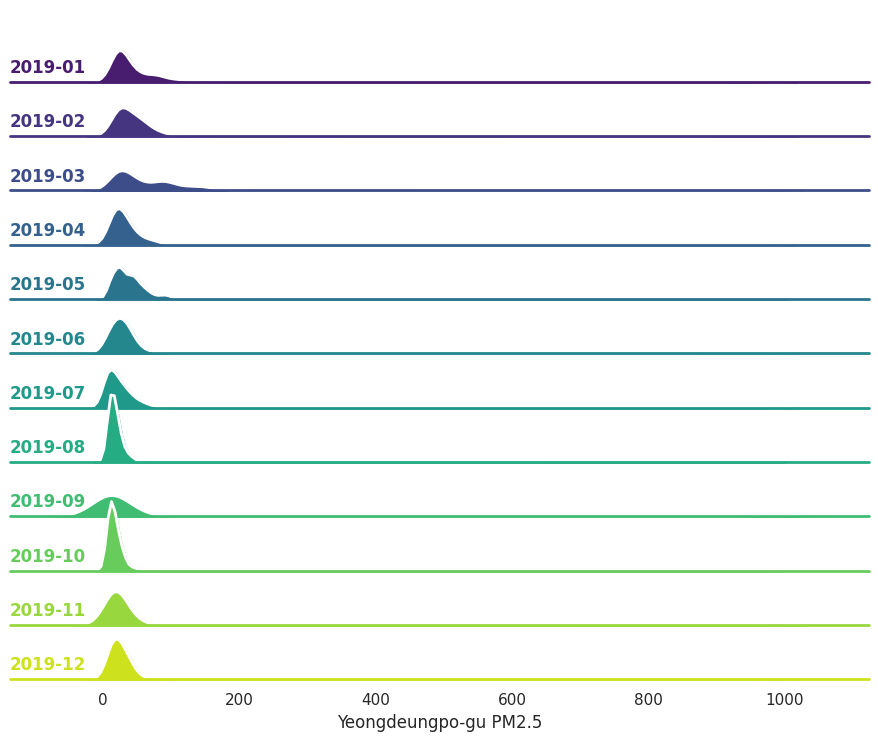

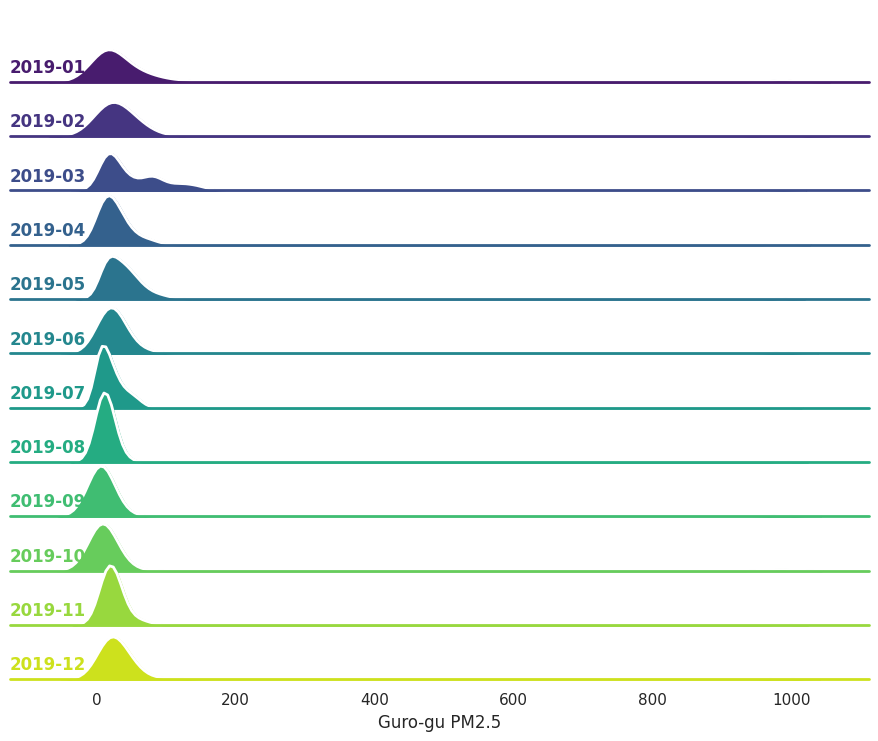

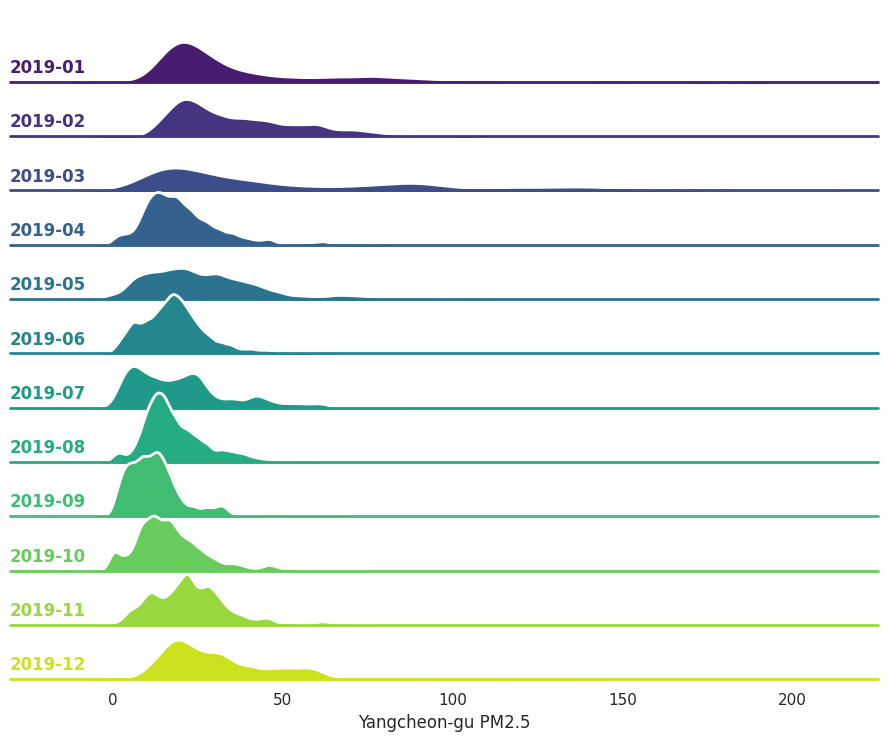

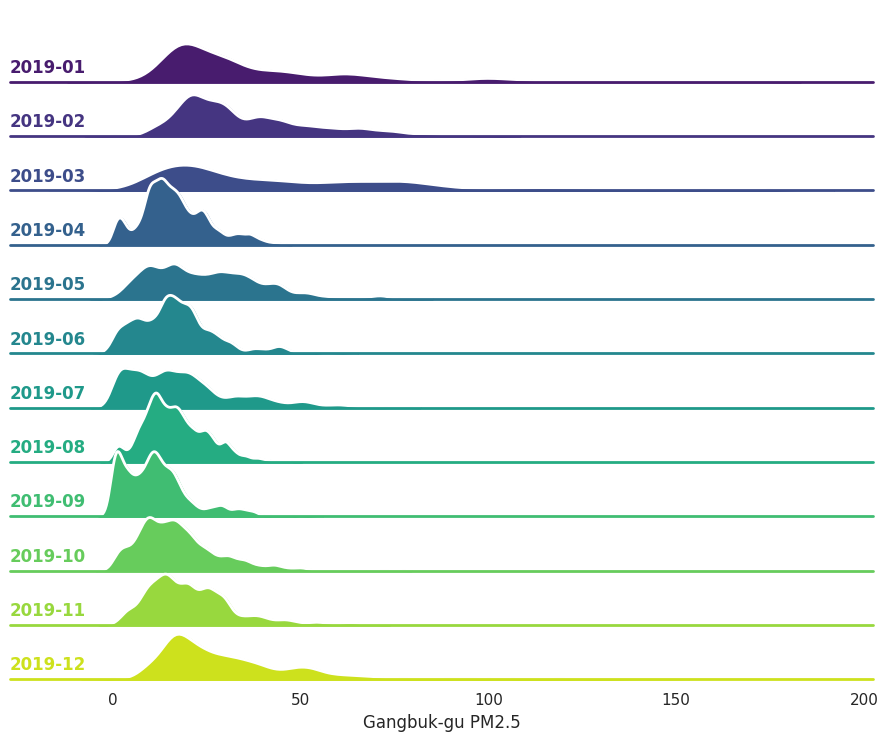

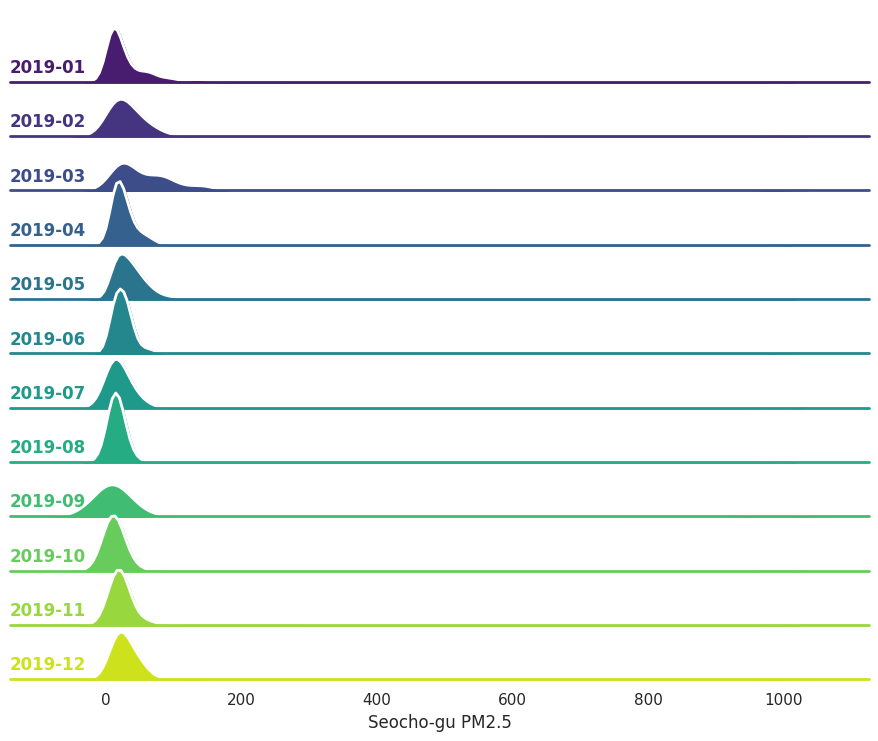

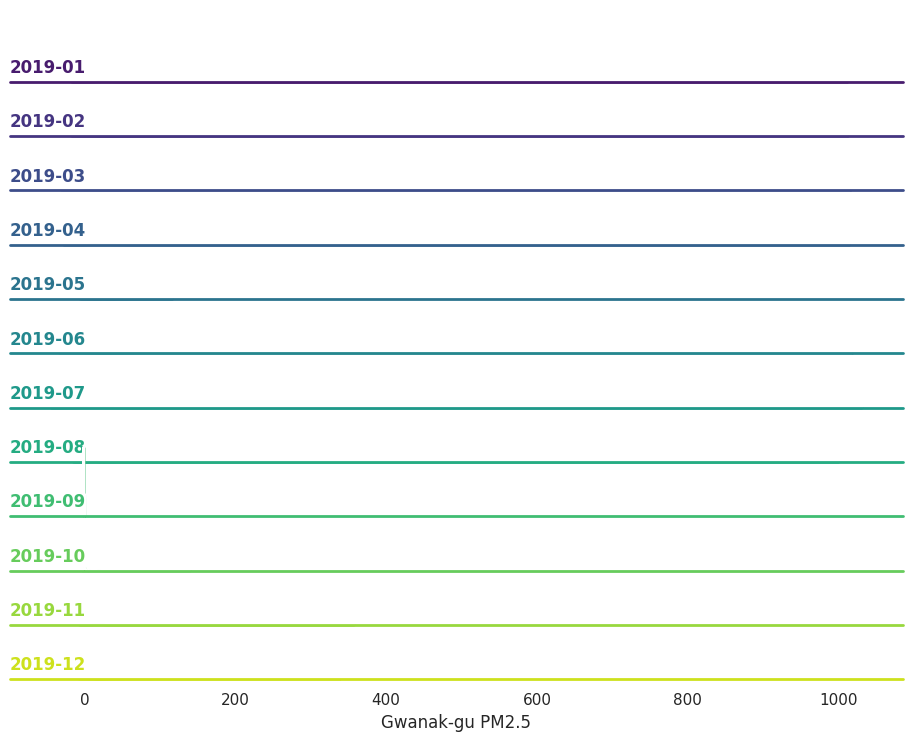

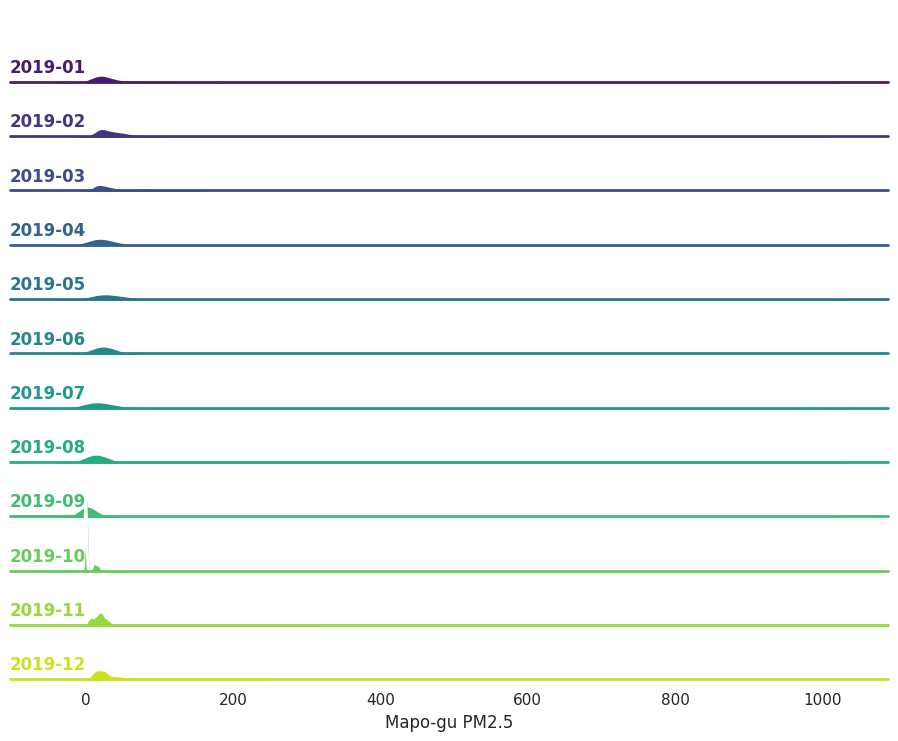

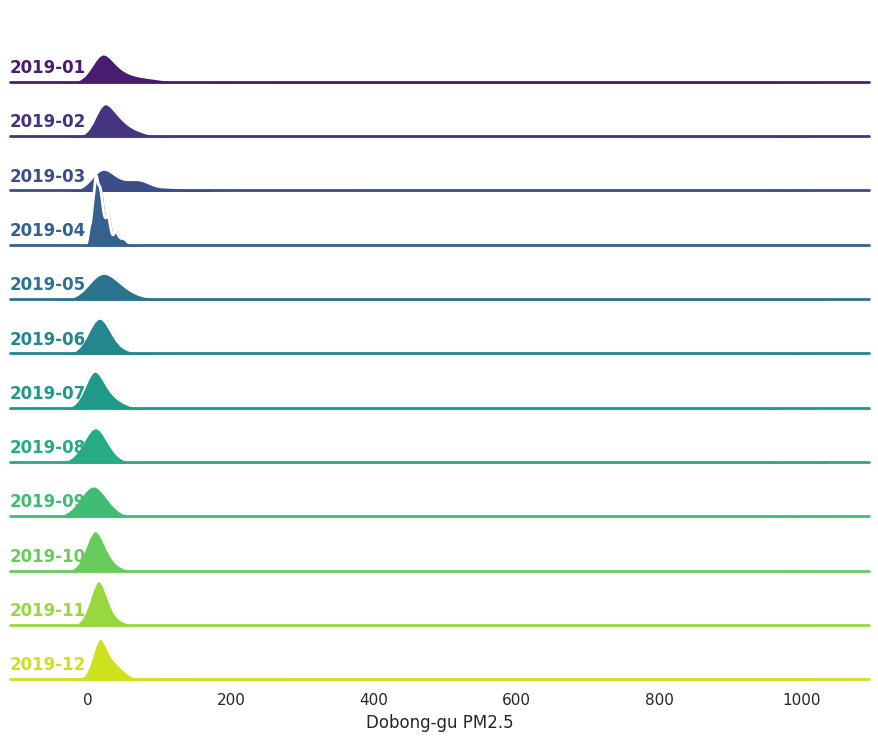

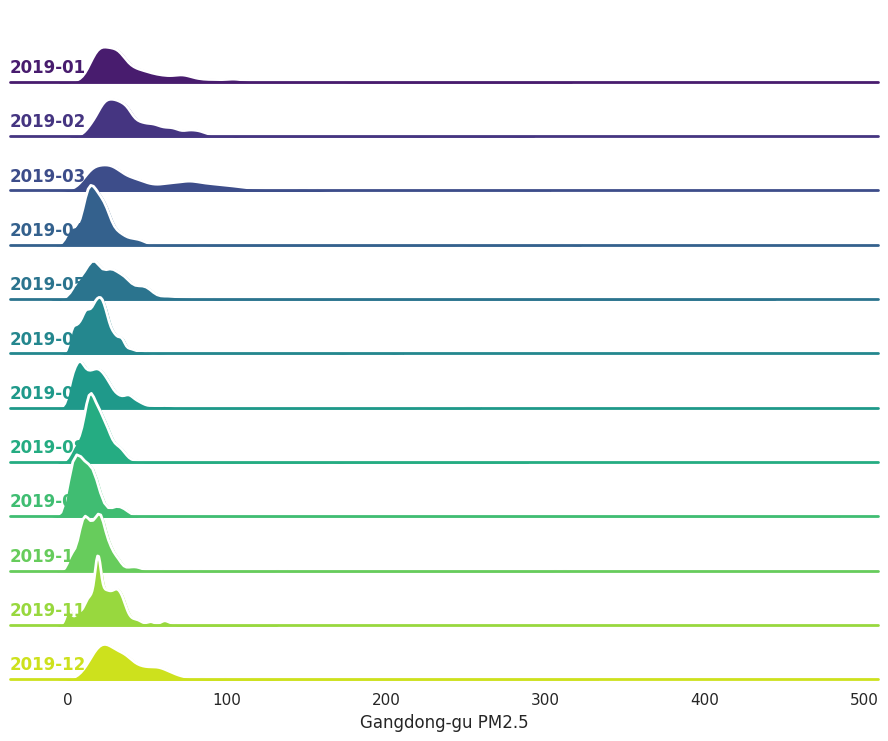

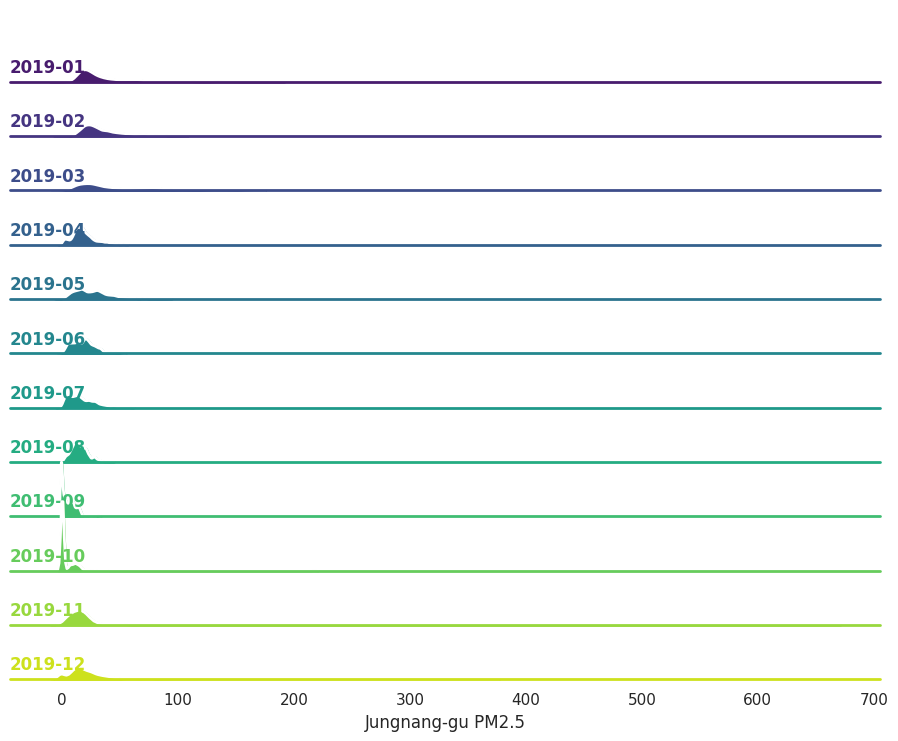

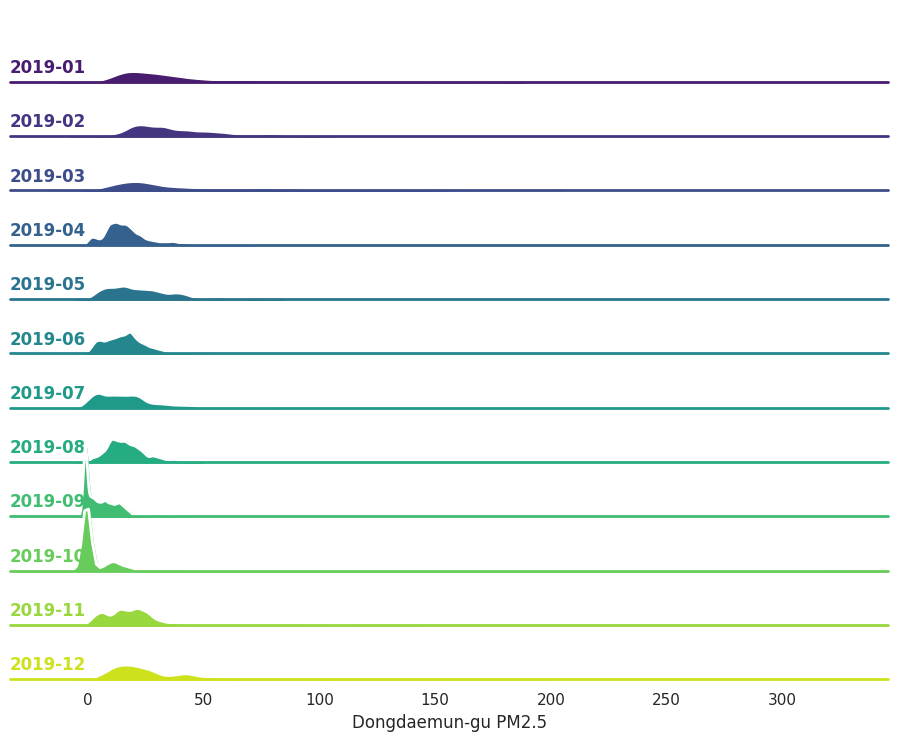

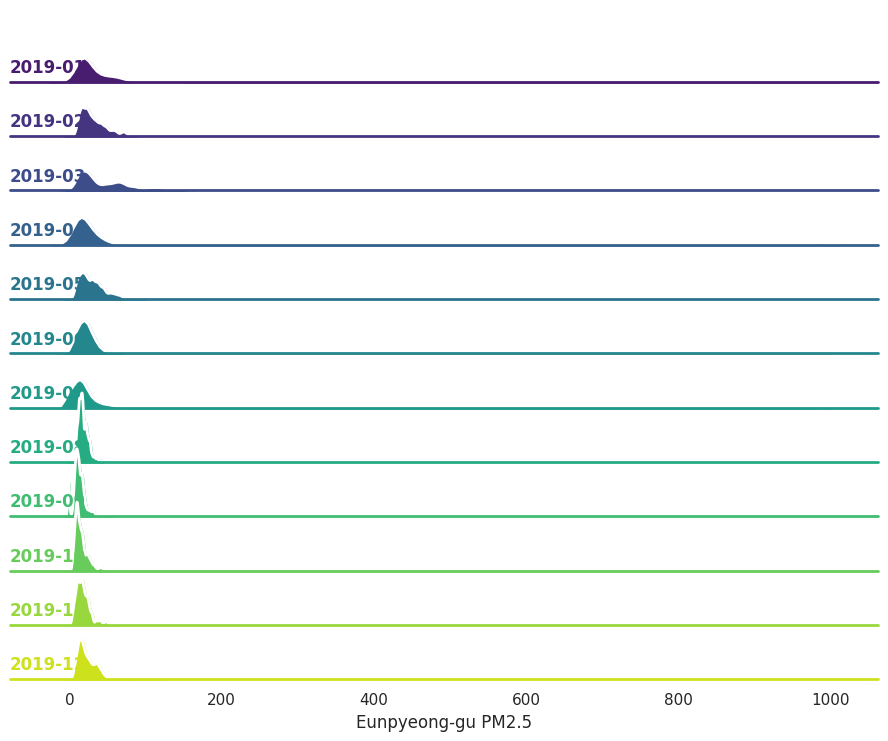

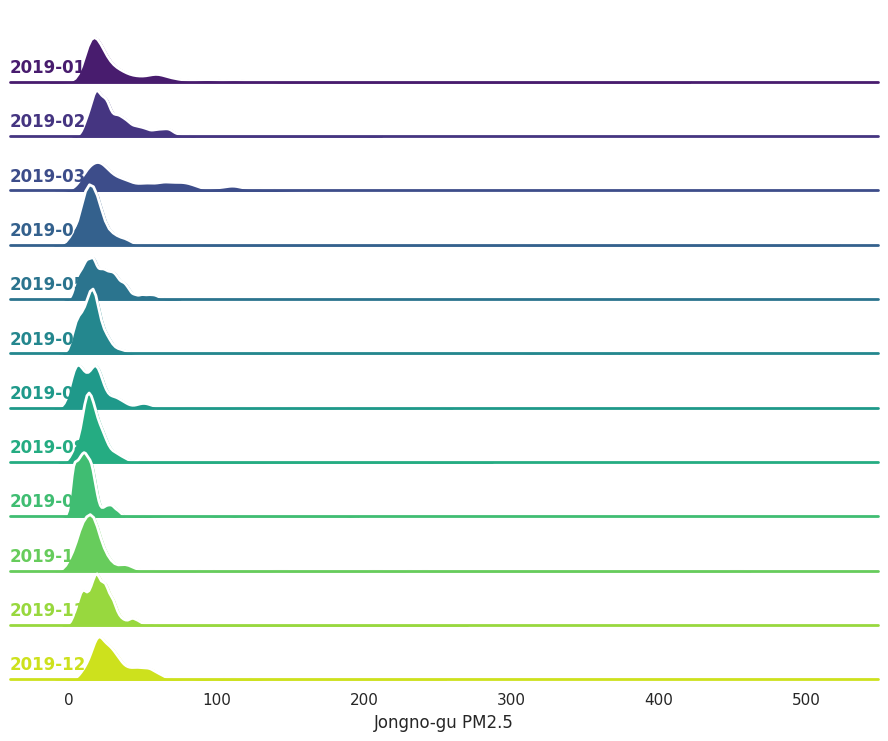

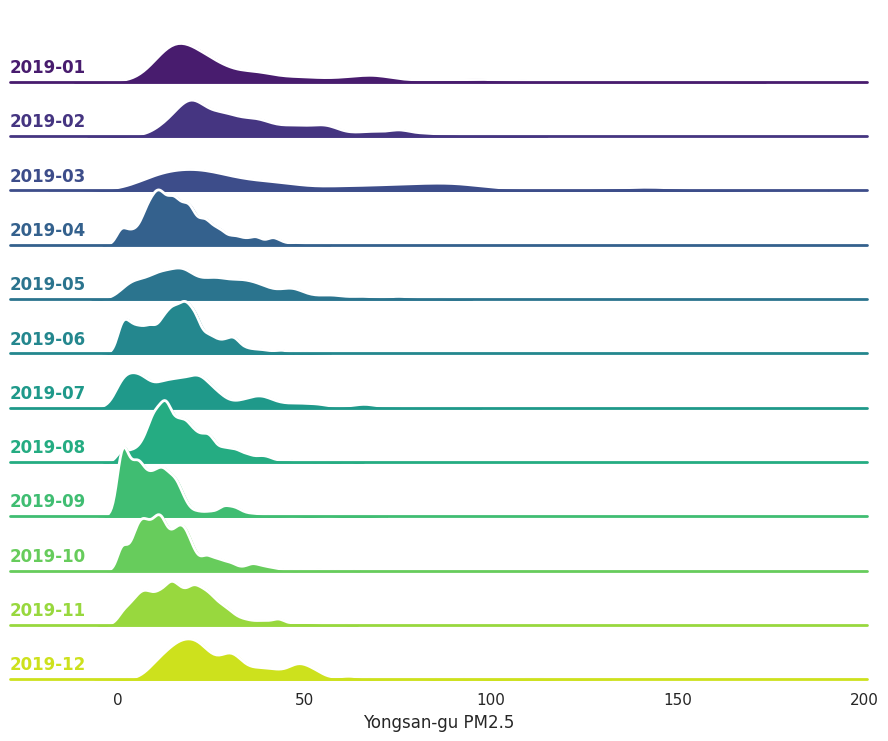

In [29]:
#use hourly data
df_hour19 = df[df['Year']=='2019']
df_hd19 = [df_hour19[df_hour19['District']==i] for i in list_district]

keep_sname = []
order = range(len(list_district))
for i in order:
    kde_ridge(df_hd19[i], 'PM2.5', 'YM', list_district[i])
    keep_sname.append('kde_' + str(i) + '.png')
    plt.savefig('kde_' + str(i) + '.png')
    plt.show()